#SPEED DATING
*   What are the important criteria of opposite sex before dating ? 
*   Does people change these criteria when they meet their match in 4 minutes ? 
*   Which principal factors to decide to say "Yes" ?

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import files

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import cross_val_score
from sklearn.inspection import permutation_importance
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

from  collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import RandomOverSampler


In [ ]:
uploaded = files.upload()

Saving Speed Dating Data.csv to Speed Dating Data.csv


In [ ]:
df = pd.read_csv('Speed Dating Data.csv', encoding="ISO-8859-1", engine='python')

In [ ]:
df.shape

(8378, 195)

In [ ]:
df.describe(include='all')

iid           id  ...       fun5_3       amb5_3
count   8378.000000  8377.000000  ...  2016.000000  2016.000000
unique          NaN          NaN  ...          NaN          NaN
top             NaN          NaN  ...          NaN          NaN
freq            NaN          NaN  ...          NaN          NaN
mean     283.675937     8.960248  ...     7.155258     7.048611
std      158.583367     5.491329  ...     1.672787     1.717988
min        1.000000     1.000000  ...     1.000000     1.000000
25%      154.000000     4.000000  ...     6.000000     6.000000
50%      281.000000     8.000000  ...     7.000000     7.000000
75%      407.000000    13.000000  ...     8.000000     8.000000
max      552.000000    22.000000  ...    10.000000    10.000000

[11 rows x 195 columns]

In [ ]:
null_features = df.columns[df.isnull().sum()/df.shape[0] >= 0.5]
print('Features with empty values >=50% : {}'.format(len(null_features)))
print()
print(null_features)

Features with empty values >=50% : 59

Index(['mn_sat', 'tuition', 'expnum', 'attr1_s', 'sinc1_s', 'intel1_s',
       'fun1_s', 'amb1_s', 'shar1_s', 'attr3_s', 'sinc3_s', 'intel3_s',
       'fun3_s', 'amb3_s', 'attr7_2', 'sinc7_2', 'intel7_2', 'fun7_2',
       'amb7_2', 'shar7_2', 'you_call', 'them_cal', 'date_3', 'numdat_3',
       'num_in_3', 'attr1_3', 'sinc1_3', 'intel1_3', 'fun1_3', 'amb1_3',
       'shar1_3', 'attr7_3', 'sinc7_3', 'intel7_3', 'fun7_3', 'amb7_3',
       'shar7_3', 'attr4_3', 'sinc4_3', 'intel4_3', 'fun4_3', 'amb4_3',
       'shar4_3', 'attr2_3', 'sinc2_3', 'intel2_3', 'fun2_3', 'amb2_3',
       'shar2_3', 'attr3_3', 'sinc3_3', 'intel3_3', 'fun3_3', 'amb3_3',
       'attr5_3', 'sinc5_3', 'intel5_3', 'fun5_3', 'amb5_3'],
      dtype='object')


#Decision of participants

Text(0.5, 1.0, 'Decision')

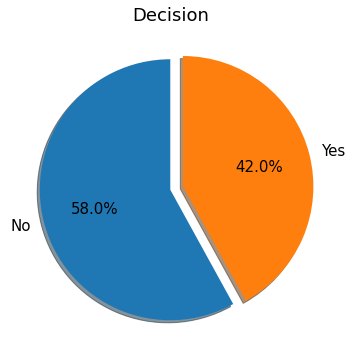

In [ ]:
decision = ['dec']
dec = ['No', 'Yes']

plt.figure(figsize=(6,6))
plt.rcParams.update({'font.size': 15})
plt.pie(df['dec'].value_counts(), autopct='%1.1f%%',shadow=True, startangle=90, explode = (0, 0.1), labels=dec)
plt.title('Decision')


#Do they match (yes-yes) ?

Text(0.5, 1.0, 'Decision')

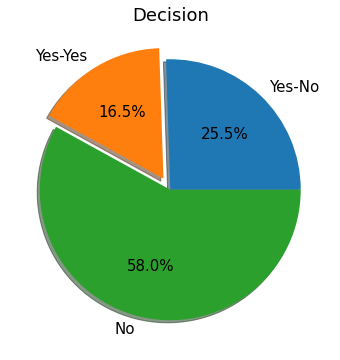

In [ ]:
yes_yes = df[(df['dec']==1)&(df['dec_o']==1)]['dec'].sum()/df.shape[0] #Me : Yes, Partner : Yes
yes_no  = df[(df['dec']==1)&(df['dec_o']==0)]['dec'].sum()/df.shape[0] #Me : Yes, Partner : No
no      =  1 - yes_no - yes_yes                                        #Me : No

dec_labels = ['yes_no','yes_yes=match', 'no']
df_dec = [yes_no,yes_yes, no]

plt.figure(figsize=(6,6))
plt.rcParams.update({'font.size': 15})
plt.pie(df_dec, autopct='%1.1f%%',shadow=True, startangle=0, explode = (0, 0.1, 0), labels= ['Yes-No', 'Yes-Yes', 'No'])
plt.title('Decision')

In [ ]:
rate_match_when_yes = yes_yes/(yes_yes + yes_no)
round(rate_match_when_yes*100,2)

39.23

So, even when you say "yes", you have only 39% chance to have a match.

#Correlation between decision and match

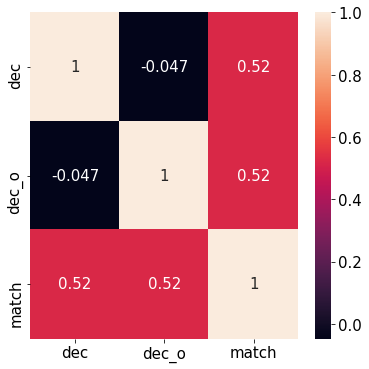

In [ ]:
df_dec_match = df[['dec', 'dec_o', 'match']] #decision of participant, partner & match between them

plt.figure(figsize=(6,6))
sns.heatmap(df_dec_match.corr(), annot=True)

* Really strong correlation between decision of people and their match. So that, I will analyze impact of features in dataset on their decision. 
* Note : people does not know their partner's decision. Hence, there is no correlation between decisions. 

Define some functions
*   Get annotation



In [ ]:
def get_annot(ax, distance_to_bar = 0.5, decimal=1):
#to get annotation on barplot
#ax : axis to apply 
#distance_to_bar : distance of annot. position to bar
# decimal : number of decimal 
    for p in ax.patches:
        height = round((p.get_height()),decimal) + distance_to_bar
        ax.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center", fontsize=15)

* Plot the ROC curves for all classes
* n_classes : number of classes to classification
* y_target : true label in target
* y_score_probas : prediction probability of model on X_test 

In [ ]:
def get_ROC(n_classes, y_target, y_score_probas):
    colors = ['blue', 'red']*int(n_classes/2)
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = roc_auc_score(y_test_dummies[:, i], y_score[:, i])


    plt.figure(figsize=(8,6))
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.title('GBoost : ROC curve', fontsize=18)
    plt.rcParams.update({'font.size': 15})
    plt.show()

#Who are participants ?

*   Age
*   Race
*   From ? 
*   Field of study
*   Income





In [ ]:
race = ['Africain', 'European', 'Latino',  'Asian', 'Other']
gender = ['Female', 'Male']
field_cd = ['Law', 'Math', 'Soc. Scien.', 'Med. Scien.', 'Eng.', 'Jour.', 'Hist.', 'Econ', 'Aca.', 'Nat. Scien.', 'Soc. Work', 'Undergrad', 'Pol. Scien.', 'Film', 'Art', 'Lang.', 'Arch.', 'Other']

Text(0.5, 1.0, 'Gender')

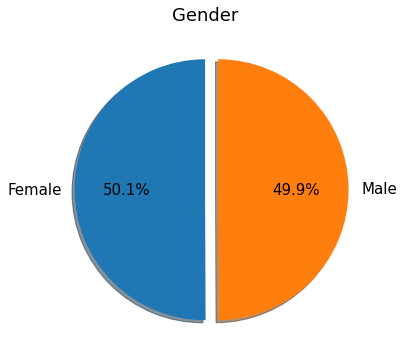

In [ ]:
plt.figure(figsize=(6,6))
plt.pie(df['gender'].value_counts(), autopct='%1.1f%%',shadow=True, startangle=90, explode = (0, 0.1), labels=gender)
plt.title('Gender')

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


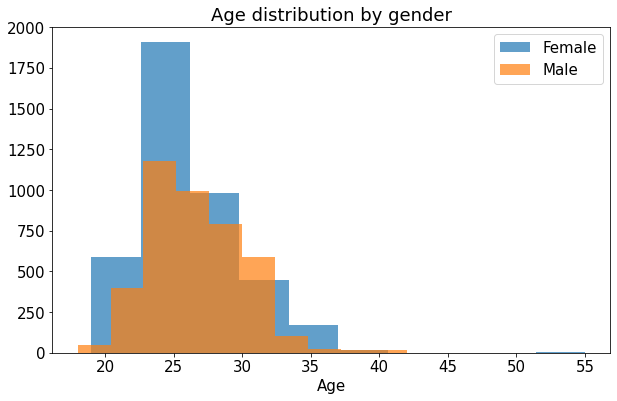

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
ax.hist(df[df['gender']==0]['age'], alpha= 0.7, label='Female')
ax.hist(df[df['gender']==1]['age'], alpha= 0.7, label='Male')
plt.legend()
plt.xlabel('Age')
plt.title('Age distribution by gender', fontsize=18)
plt.show()

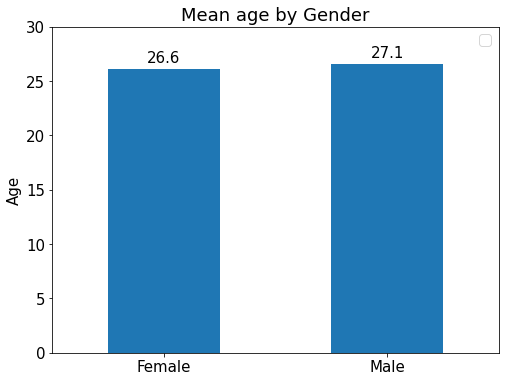

In [ ]:
ax = df[['gender', 'age']].groupby(['gender']).mean().plot(kind='bar', figsize=(8,6))
ax.set_xticklabels(gender, rotation='horizontal')
ax.set_title('Mean age by Gender')
ax.set_ylim([0, 30])
plt.xlabel('')
plt.ylabel('Age')
plt.legend('')
get_annot(ax=ax)
plt.rcParams.update({'font.size': 20})


In [ ]:
df[['race', 'gender']].groupby('race').count()

gender
race        
1.0      420
2.0     4727
3.0      664
4.0     1982
6.0      522

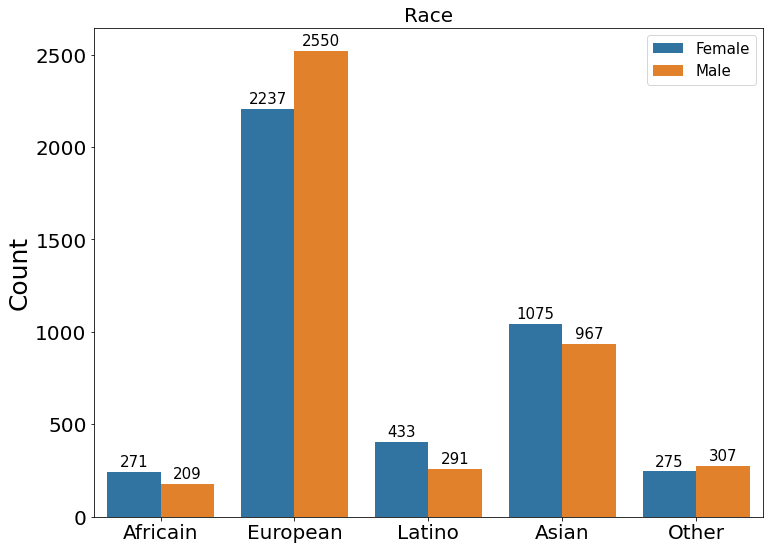

In [ ]:
fig, ax = plt.subplots(figsize=(12,9))
ax = sns.countplot(data=df, x='race', hue='gender')

ax.legend(gender, fontsize=15)
ax.set_xticklabels(race)
plt.xlabel('')
plt.ylabel('Count', fontsize=25)
plt.title('Race', fontsize=20)

get_annot(ax, distance_to_bar=30, decimal=0)
plt.rcParams.update({'font.size': 20})
plt.show()

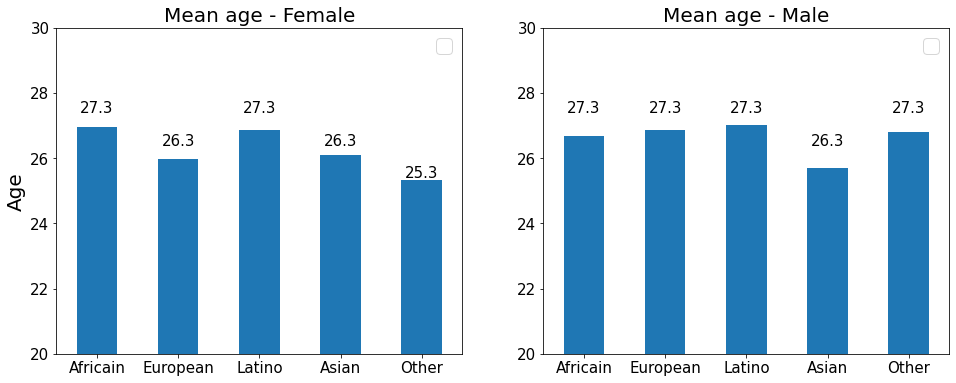

In [ ]:
fig, ax= plt.subplots(1,2, figsize=(16, 6))

df[df['gender']==0][['race', 'age']].groupby(['race']).mean().plot(kind='bar', ax=ax[0], ylim=(20,30))
df[df['gender']==1][['race', 'age']].groupby(['race']).mean().plot(kind='bar', ax=ax[1], ylim=(20,30))

ax[0].set_xticklabels(race, fontsize=15, rotation='horizontal')
ax[0].set_title('Mean age - Female', fontsize=20)
ax[0].tick_params(labelsize=15)
ax[0].set_xlabel('')
ax[0].set_ylabel('Age')
ax[0].legend('')
get_annot(ax=ax[0], decimal=0, distance_to_bar=0.3)

ax[1].set_xlabel('',fontsize=1)
ax[1].set_xticklabels(race, fontsize=15, rotation='horizontal')
ax[1].set_title('Mean age - Male', fontsize=20)
ax[1].legend('')
ax[1].tick_params(labelsize=15)
get_annot(ax=ax[1], decimal=0, distance_to_bar=0.3)

Decision vs. Age, Race

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


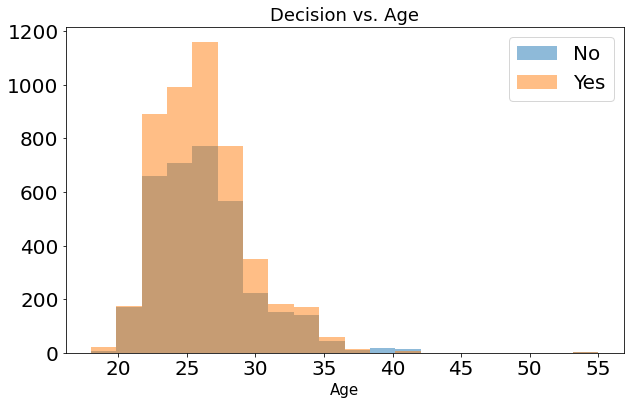

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
ax.hist(df[df['dec']==1]['age'], alpha= 0.5, label='No', bins=20)
ax.hist(df[df['dec']==0]['age'], alpha= 0.5, label='Yes', bins=20)

plt.legend()
plt.xlabel('Age', fontsize=15)
plt.title('Decision vs. Age', fontsize=18)
plt.rcParams.update({'font.size': 20})
plt.show()

It's seem to be that people between 22-30 years old will decide to say "Yes" more frequently

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


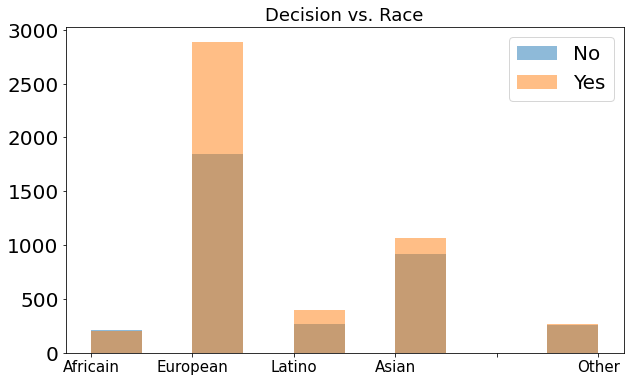

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
ax.hist(df[df['dec']==1]['race'], alpha= 0.5, label='No')
ax.hist(df[df['dec']==0]['race'], alpha= 0.5, label='Yes')

plt.legend()
plt.xlabel('', fontsize=15)
ax.set_xticklabels(['', 'Africain', 'European', 'Latino',  'Asian','' ,'Other'],rotation=0, fontsize=15)
plt.title('Decision vs. Race', fontsize=18)
plt.rcParams.update({'font.size': 20})
plt.show()

*   European race have much "Yes" decision than "No"
*   Latino & Asian race : more "Yes" than "No"
*   For Africain & Other : chance of "Yes" and "No" are equilibrium



Field of study

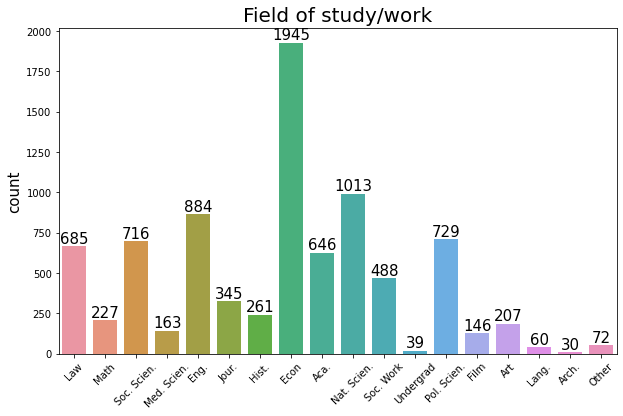

In [ ]:
plt.figure(figsize=(10,6))
ax = sns.countplot(df['field_cd'])

ax.set_title('Field of study/work', fontsize=20)
ax.set_xlabel('')
ax.set_xticklabels(field_cd,rotation=45)
ax.tick_params(labelsize=10)
ax.set_ylabel('count', fontsize=15)

get_annot(ax, distance_to_bar=20, decimal=0)
plt.show()

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


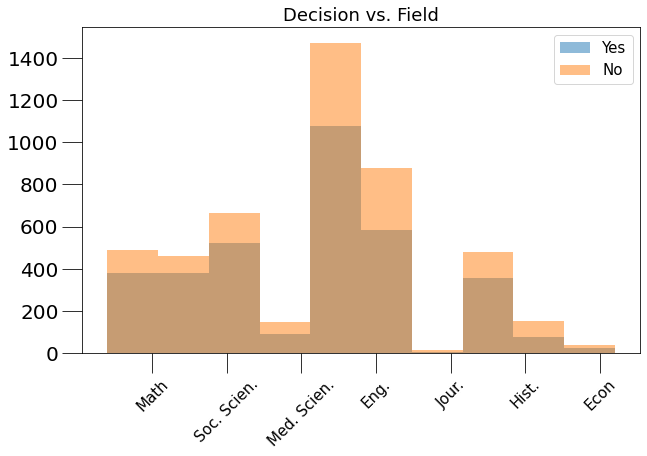

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
ax.hist(df[df['dec']==1]['field_cd'], alpha= 0.5, label='Yes')
ax.hist(df[df['dec']==0]['field_cd'], alpha= 0.5, label='No')

plt.legend()
plt.xlabel('', fontsize=15)
ax.set_xticklabels(field_cd,rotation=45, fontsize=15)
plt.title('Decision vs. Field', fontsize=18)
plt.legend(prop={'size': 15})
plt.tick_params(size=20)
plt.show()

In [ ]:
dec_yes_field = (df[['dec', 'field_cd']].groupby(['field_cd']).sum()/df[['dec', 'field_cd']].groupby(['field_cd']).count())
dec_yes_field

dec
field_cd          
1.0       0.463158
2.0       0.352657
3.0       0.448276
4.0       0.468531
5.0       0.472222
6.0       0.350769
7.0       0.385892
8.0       0.412468
9.0       0.453674
10.0      0.435045
11.0      0.326923
12.0      0.263158
13.0      0.406206
14.0      0.539683
15.0      0.315508
16.0      0.400000
17.0      0.200000
18.0      0.423077

We see that the 'Yes' rate varies for different field, but this variation isn't explicit. We will see more in the correlation map.



From where ?

In [ ]:
regions = df['from'].value_counts()
print('People from {} regions'.format(len(regions)))
print(regions)

People from 269 regions
New York          522
New Jersey        365
California        301
China             139
Italy             132
                 ... 
sofia, bg           5
china               5
Pougkeepsie NY      5
Greenwich, CT       5
Europe              5
Name: from, Length: 269, dtype: int64


It's difficult to say if a regions have more "Yes" than "No" when we have many places.

In [ ]:
print('Participant income : empty values is {:2.2%}'.format(df['income'].isnull().sum()/df.shape[0]))


Participant income : empty values is 48.93%


As the income subject is quite sensible to ask when we see each other in only 4 minutes, and income change a lot in function of experience years, fields and companies, I suggest that the decision in Speed Dating does not depend much on the income. 

#Importance of Race, Importance of Regiligion 
Does people care about that ?

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


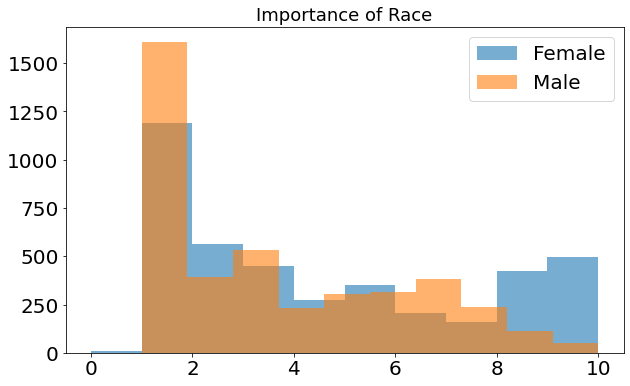

In [ ]:
plt.figure(figsize=(10,6))
plt.hist(df[df['gender']==0]['imprace'], alpha= 0.6, label='Female')
plt.hist(df[df['gender']==1]['imprace'], alpha= 0.6, label='Male')
plt.legend()
plt.title('Importance of Race', fontsize=18)

plt.show()

In [ ]:
print('Percent of Female who considers Importance of Race is more than 7 :')
print('{:2.2%}'.format(df[(df['gender']==0) & (df['imprace']>7)]['imprace'].count()/df.shape[0]))

Percent of Female who considers Importance of Race is more than 7 :
10.99%


Male seem to be do not care much on the race, while 11% of female rate this critera is important.

dec          0     1
samerace            
0         2983  2079
1         1877  1439


[Text(0, 0, 'Diff. Race'), Text(0, 0, 'Same Race')]

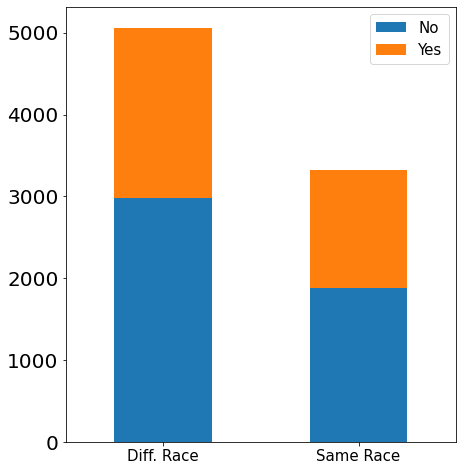

In [ ]:
df_imprace = df.groupby(['samerace', 'dec']).size().reset_index().pivot(columns='dec', index='samerace', values=0)
print(df_imprace)
ax = df_imprace.plot(kind='bar', stacked=True, figsize=(7,8))
plt.legend(['No', 'Yes'],fontsize=15)
plt.xlabel('')
plt.rcParams.update({'font.size': 20})
ax.set_xticklabels(['Diff. Race', 'Same Race'], fontsize=15, rotation=0)

In [ ]:
print('Decision vs.Samerace')
df_race_imprace = df[['dec','samerace', 'race']].groupby(['race','samerace']).mean()*100
df_race_imprace

Decision vs.Samerace


dec
race samerace           
1.0  0         49.502488
     1         77.777778
2.0  0         33.549675
     1         42.988253
3.0  0         39.869281
     1         48.076923
4.0  0         46.870839
     1         43.750000
6.0  0         50.000000
     1         45.238095

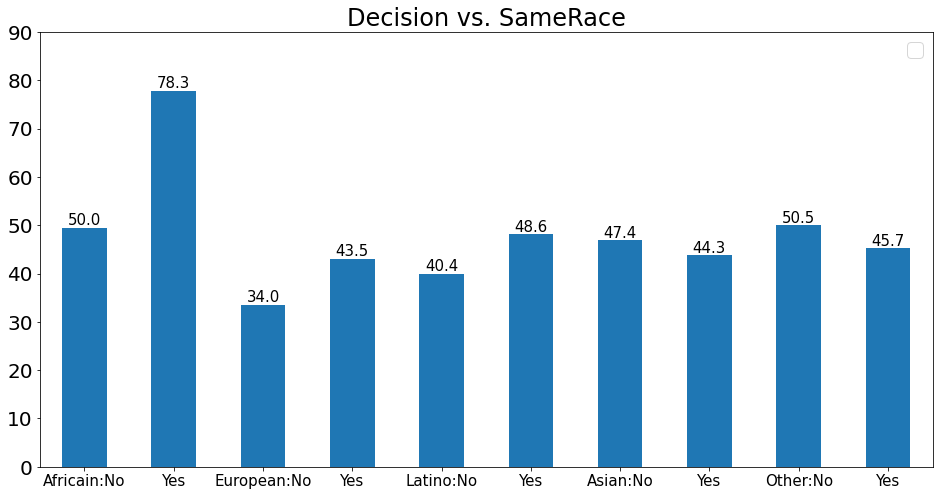

In [ ]:
ax = df_race_imprace.plot(kind='bar',stacked=True, figsize=(16,8))
plt.legend('')
plt.ylim([0,90])
plt.xlabel('')
plt.rcParams.update({'font.size': 20})
ax.set_xticklabels(['Africain:No','Yes', 'European:No','Yes', 'Latino:No','Yes',  'Asian:No','Yes', 'Other:No','Yes'], fontsize=15, rotation=0)
plt.title('Decision vs. SameRace')
get_annot(ax=ax, decimal=1)
plt.show()

We don't see an explicit dependance of Samerace on Decision (previous figure). However, this is importance for Africain to say Yes or No. 

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


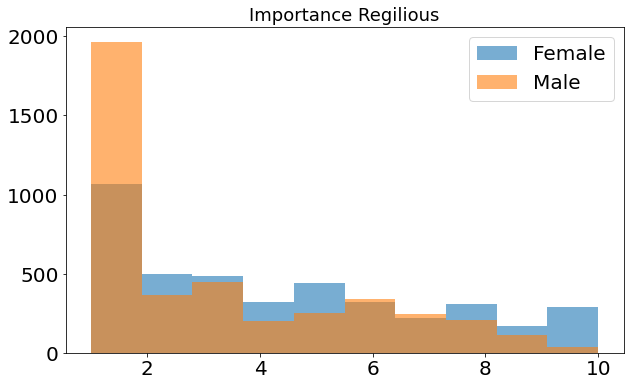

In [ ]:
plt.figure(figsize=(10,6))
plt.hist(df[df['gender']==0]['imprelig'], alpha= 0.6, label='Female')
plt.hist(df[df['gender']==1]['imprelig'], alpha= 0.6, label='Male')
plt.legend()
plt.title('Importance Regilious', fontsize=18)

plt.show()

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


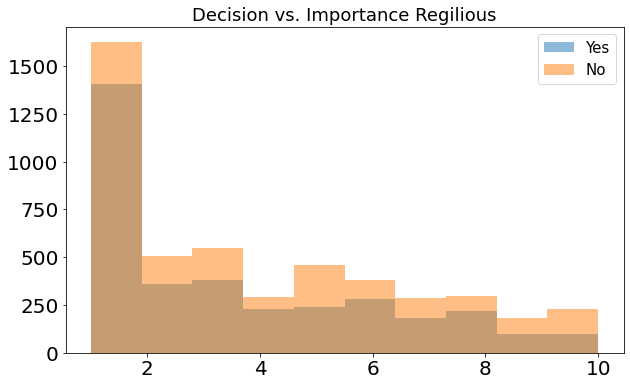

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
ax.hist(df[df['dec']==1]['imprelig'], alpha= 0.5, label='Yes')
ax.hist(df[df['dec']==0]['imprelig'], alpha= 0.5, label='No')

plt.legend()
plt.xlabel('', fontsize=15)
plt.title('Decision vs. Importance Regilious', fontsize=18)
plt.legend(prop={'size': 15})
plt.show()

In these 2 graphs, the decision does not explicitly depend on the rate of importance regilious.

#Before Dating

*   Goal, Expectation of Happy, Exp. of Date, exp. of match : goal, exphappy,expnum, match_es
*   Attributes of partner : attr1_1 (Attractive), sinc1_1 (Sincere), intel1_1 (Intelligent), fun1_1(Fun), amb1_1 (Ambitious), shar1_1 (Has shared interests/hobbies)



Expectation

In [ ]:
goal = ['','fun', 'meet pp.', 'a date', 'ser. relat.', 'did it', 'other']
df['goal'].value_counts()

1.0    3426
2.0    3012
3.0     631
5.0     510
6.0     419
4.0     301
Name: goal, dtype: int64

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


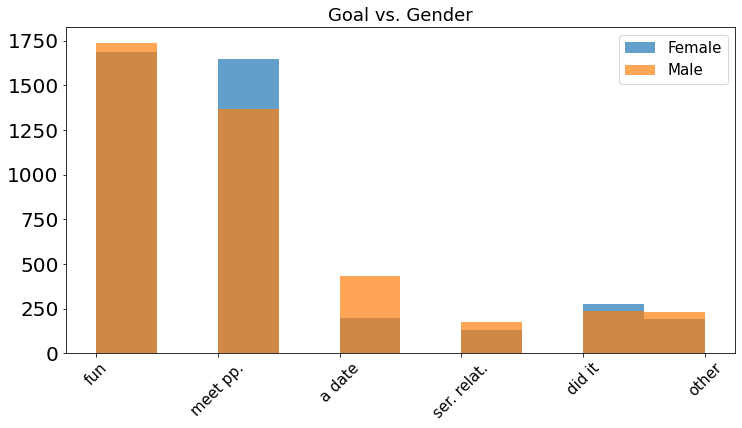

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
ax.hist(df[df['gender']==0]['goal'], alpha= 0.7, label='Female')
ax.hist(df[df['gender']==1]['goal'], alpha= 0.7, label='Male')
plt.legend(fontsize=15)
ax.set_xticklabels(goal,rotation=45, fontsize=15)
plt.xlabel('')
plt.title('Goal vs. Gender', fontsize=18)
plt.rcParams.update({'font.size': 20})
plt.show()

More of man looks for a date and serious relationship in Speed Dating than woman

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


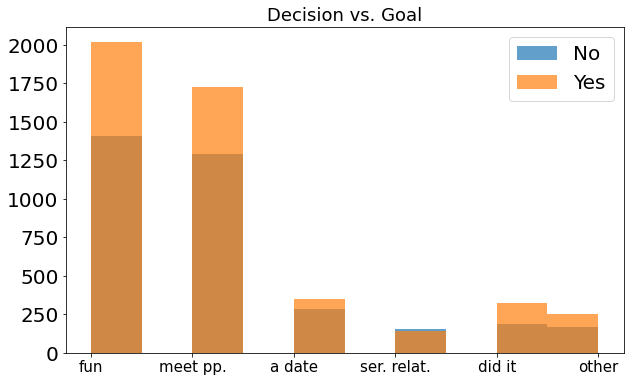

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
ax.hist(df[df['dec']==1]['goal'], alpha= 0.7, label='No')
ax.hist(df[df['dec']==0]['goal'], alpha= 0.7, label='Yes')

plt.legend()
plt.xlabel('', fontsize=15)
ax.set_xticklabels(['','fun', 'meet pp.', 'a date', 'ser. relat.', 'did it', 'other'],rotation=0, fontsize=15)
plt.title('Decision vs. Goal', fontsize=18)
plt.rcParams.update({'font.size': 15})
plt.show()

People can say "yes" easily if they come to Speed Dating with fun, meet pp. goal; while they are more selective when finding a serious relationship.

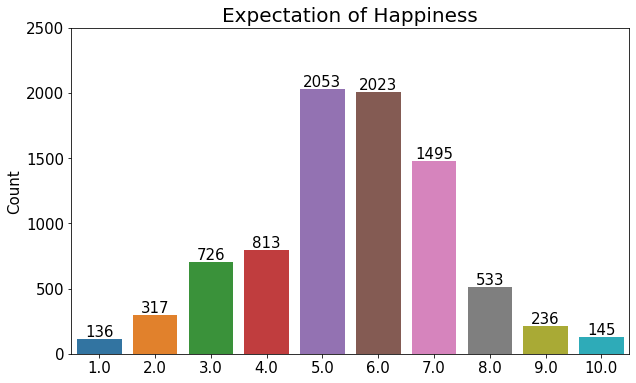

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))

sns.countplot(data=df, x='exphappy')
plt.title('Expectation of Happiness', fontsize=20)
plt.xlabel('')
plt.ylabel('Count', fontsize=15)
plt.ylim([0,2500])
plt.tick_params(labelsize=15)

get_annot(ax=ax, distance_to_bar=20)

Almost people expect between 5-7 points of happiness - middle of range.

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


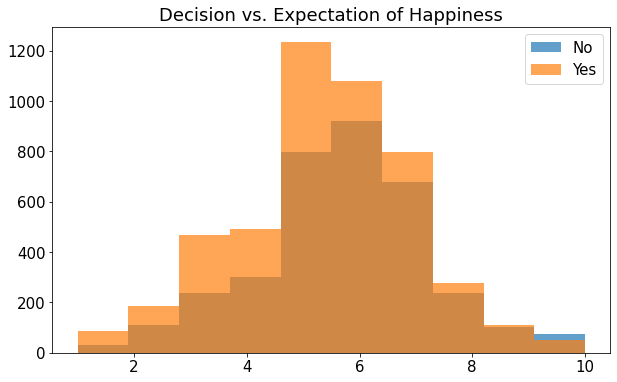

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
ax.hist(df[df['dec']==1]['exphappy'], alpha= 0.7, label='No')
ax.hist(df[df['dec']==0]['exphappy'], alpha= 0.7, label='Yes')

plt.legend()
plt.xlabel('', fontsize=15)
plt.title('Decision vs. Expectation of Happiness', fontsize=18)
plt.rcParams.update({'font.size': 15})
plt.show()

Less expectation of happiness, more easily to say Yes

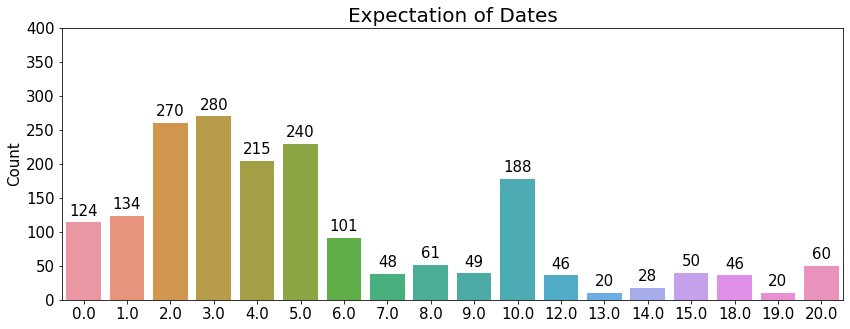

In [ ]:
fig, ax = plt.subplots(figsize=(14,5))

sns.countplot(data=df, x='expnum')
plt.title('Expectation of Dates', fontsize=20)
plt.xlabel('')
plt.ylabel('Count', fontsize=15)
plt.ylim([0,400])
plt.rcParams.update({'font.size': 15})
get_annot(ax, distance_to_bar=10, decimal=0)

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


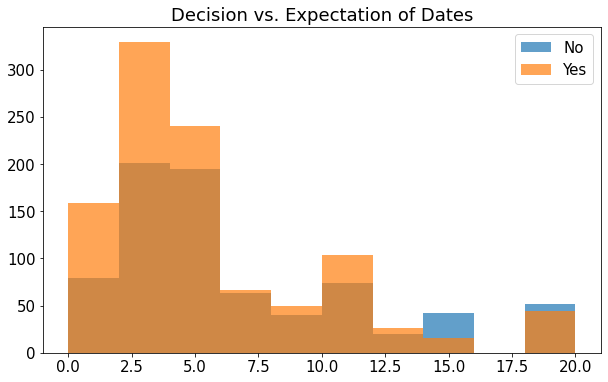

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
ax.hist(df[df['dec']==1]['expnum'], alpha= 0.7, label='No')
ax.hist(df[df['dec']==0]['expnum'], alpha= 0.7, label='Yes')

plt.legend()
#ax.set_xticklabels(['','several/w', '2/w', '1/w', '2/m.', '1/m', 'several/y', 'alm. never'],rotation=0, fontsize=12)
plt.xlabel('', fontsize=15)
plt.title('Decision vs. Expectation of Dates', fontsize=18)
plt.rcParams.update({'font.size': 15})
plt.show()

Less expectation of number of Date, more easily to say Yes

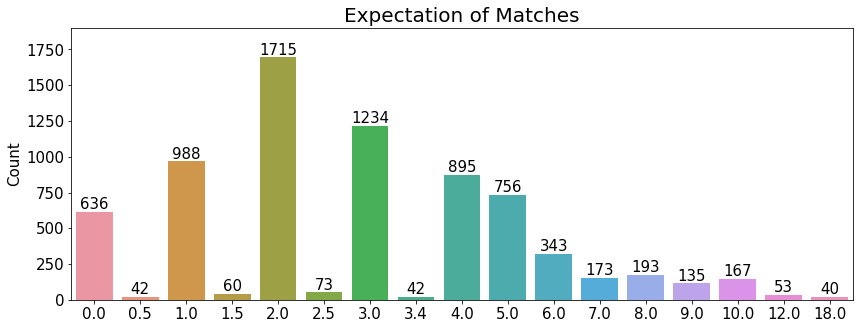

In [ ]:
fig, ax = plt.subplots(figsize=(14,5))

sns.countplot(data=df, x='match_es')
plt.title('Expectation of Matches', fontsize=20)
plt.xlabel('')
plt.ylabel('Count', fontsize=15)
plt.ylim([0,1900])
plt.rcParams.update({'font.size': 15})
get_annot(ax, distance_to_bar=20, decimal=0)

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


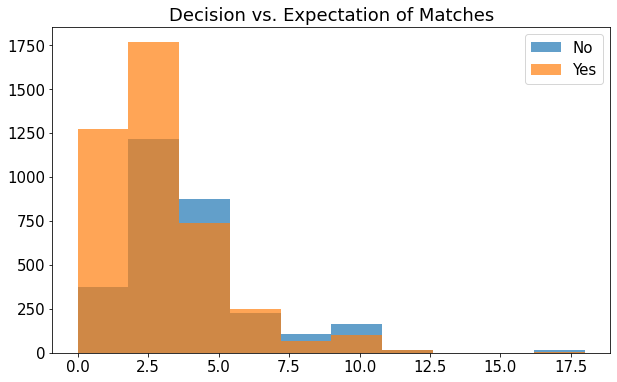

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
ax.hist(df[df['dec']==1]['match_es'], alpha= 0.7, label='No')
ax.hist(df[df['dec']==0]['match_es'], alpha= 0.7, label='Yes')

plt.legend()
#ax.set_xticklabels(['','several/w', '2/w', '1/w', '2/m.', '1/m', 'several/y', 'alm. never'],rotation=0, fontsize=12)
plt.xlabel('', fontsize=15)
plt.title('Decision vs. Expectation of Matches', fontsize=18)
plt.rcParams.update({'font.size': 15})
plt.show()

Less expectation of number of Matches, more easily to say Yes

#Before Dating
*   What are you looking for ?
*   Attributes of partner : attr1_1 (Attractive), sinc1_1 (Sincere), intel1_1 (Intelligent), fun1_1(Fun), amb1_1 (Ambitious), shar1_1 (Has shared interests/hobbies)




Text(0.5, 0.98, 'What are you looking for ?')

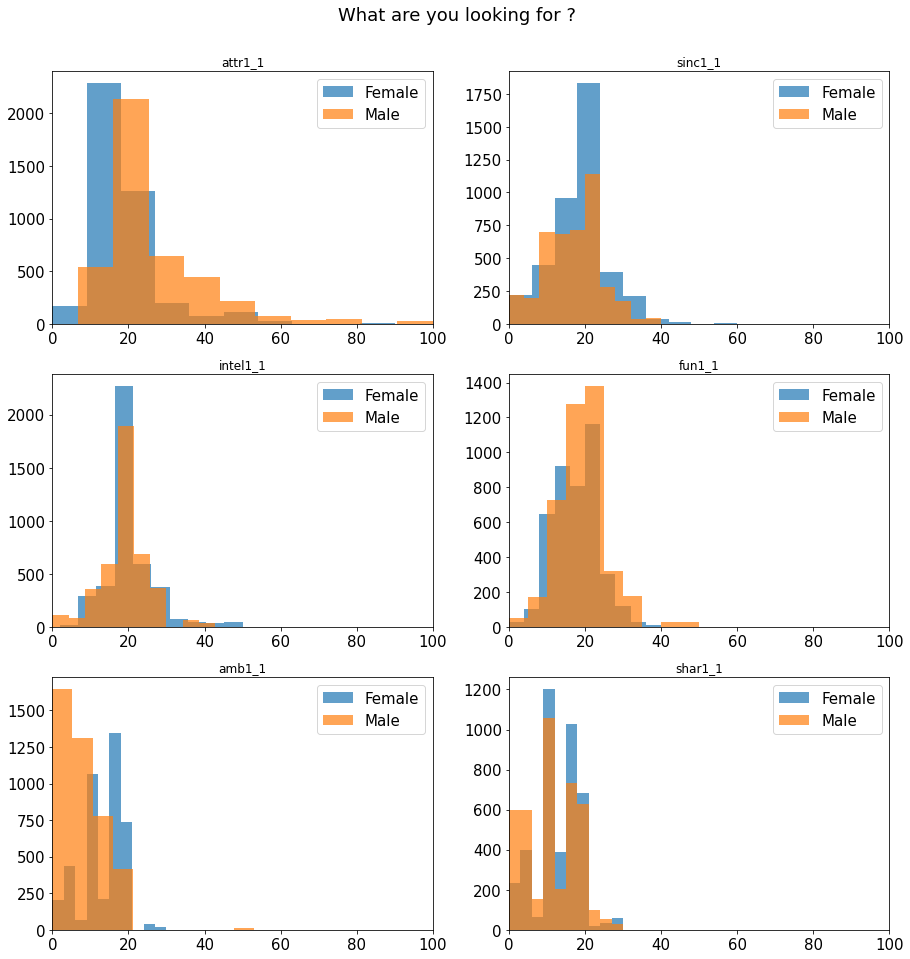

In [ ]:
features_attribute_before = ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']

num = len(features_attribute_before)
rows = int(num/2) + (num % 2 > 0)
fig, ax = plt.subplots(rows, 2, figsize=(15, 5 * (rows)))
i = 0
j = 0
for feat in features_attribute_before:
    df[df.gender==0][feat].hist(label='Female', ax=ax[i][j], bins=10, alpha=0.7)
    df[df.gender==1][feat].hist(label='Male', ax=ax[i][j], bins=10, alpha=0.7)
    ax[i][j].set_title(feat, fontsize=12)
    ax[i][j].grid(False)
    ax[i][j].legend()
    ax[i][j].set_xlim(xmin=0.0, xmax=100)
    j = (j+1)%2
    i = i + 1 - j
    
plt.subplots_adjust(top=0.92)
fig.suptitle('What are you looking for ?')

Man looks for Attractiveness, while woman looks for Ambition (as we think usally) :-)

#Decision vs. Habit
*   Frequence of Go-out, Date
*   Interests : sports,	tvsports,	exercise,	dining,	museums,	art	hiking,	gaming,	clubbing,	reading,	tv,	theater,	movies,	concerts,	music,	shopping,	yoga



In [ ]:
frequence = ['several/w', '2/w', '1/w', '2/m.', '1/m', 'several/y', 'alm. never']

Text(0.5, 1.0, 'Frequence of Go-out')

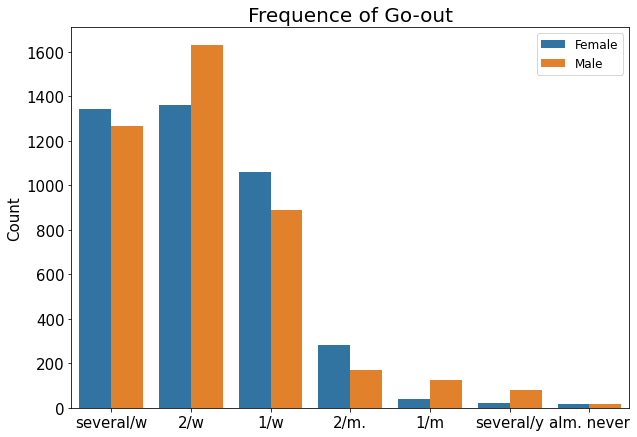

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))
sns.countplot(df['go_out'], hue=df['gender'])
ax.set_xticklabels(frequence, fontsize=15)
plt.legend(gender, fontsize=12)
plt.xlabel('')
plt.ylabel('Count', fontsize=15)
plt.title('Frequence of Go-out', fontsize=20)

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


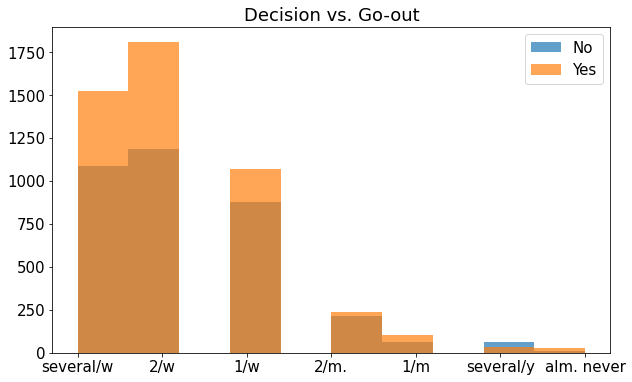

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
ax.hist(df[df['dec']==1]['go_out'], alpha= 0.7, label='No')
ax.hist(df[df['dec']==0]['go_out'], alpha= 0.7, label='Yes')

plt.legend()
plt.xlabel('', fontsize=15)
ax.set_xticklabels(['','several/w', '2/w', '1/w', '2/m.', '1/m', 'several/y', 'alm. never'],rotation=0, fontsize=15)
plt.title('Decision vs. Go-out', fontsize=18)
plt.rcParams.update({'font.size': 15})
plt.show()

People who comes out lots (several-2 times per week), say Yes easily than others

Text(0.5, 1.0, 'Frequence of Date')

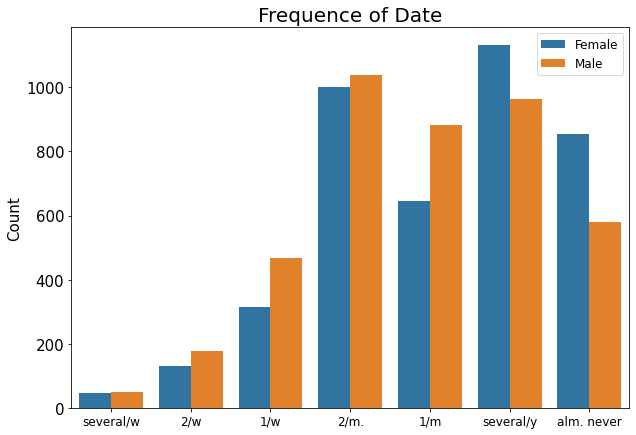

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))
sns.countplot(df['date'], hue=df['gender'])
ax.set_xticklabels(frequence, fontsize=15)
plt.legend(gender, fontsize=12)
plt.xlabel('')
ax.set_xticklabels(['several/w', '2/w', '1/w', '2/m.', '1/m', 'several/y', 'alm. never'],rotation=0, fontsize=12)
plt.ylabel('Count', fontsize=15)
plt.title('Frequence of Date', fontsize=20)

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


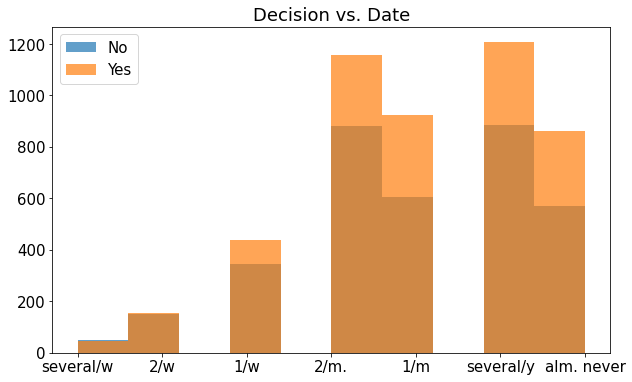

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
ax.hist(df[df['dec']==1]['date'], alpha= 0.7, label='No')
ax.hist(df[df['dec']==0]['date'], alpha= 0.7, label='Yes')

plt.legend()
ax.set_xticklabels(['','several/w', '2/w', '1/w', '2/m.', '1/m', 'several/y', 'alm. never'],rotation=0, fontsize=15)
plt.xlabel('', fontsize=15)
plt.title('Decision vs. Date', fontsize=18)
plt.rcParams.update({'font.size': 15})
plt.show()

It's is interesting that less date people has, more chance to say Yes

Text(0.5, 0.98, 'Decision vs. Interest')

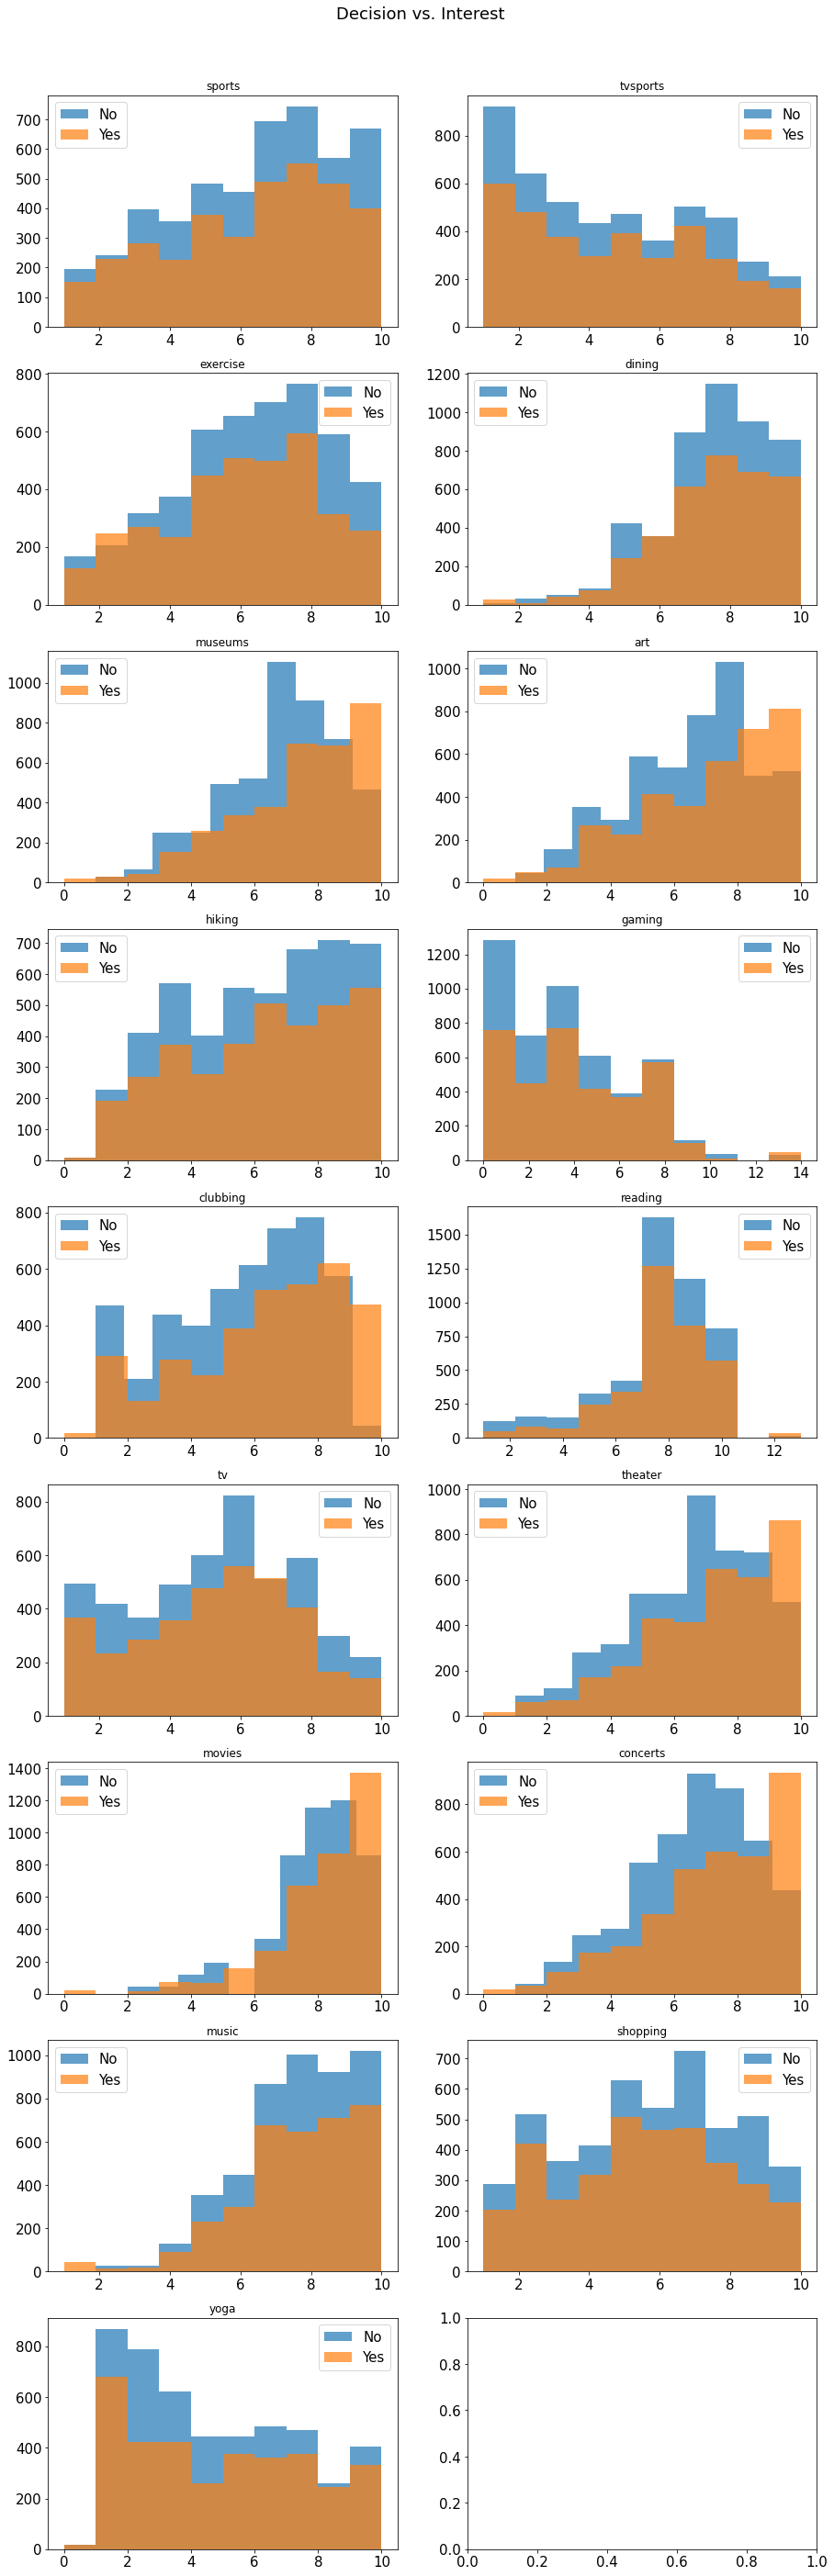

In [ ]:
feats_interest = ['sports',	'tvsports',	'exercise',	'dining',	'museums',	'art', 'hiking',	'gaming',	
                  'clubbing',	'reading',	'tv',	'theater',	'movies',	'concerts',	'music',	'shopping',	'yoga']
                  
num = len(feats_interest)
rows = int(num/2) + (num % 2 > 0)
fig, ax = plt.subplots(rows, 2, figsize=(15, 5 * (rows)))
i = 0
j = 0
for feat in feats_interest:
    df[df.dec==0][feat].hist(label='No', ax=ax[i][j], bins=10, alpha=0.7)
    df[df.dec==1][feat].hist(label='Yes', ax=ax[i][j], bins=10, alpha=0.7)
    ax[i][j].set_title(feat, fontsize=12)
    ax[i][j].grid(False)
    ax[i][j].legend()
    j = (j+1)%2
    i = i + 1 - j
    
plt.subplots_adjust(top=0.95)
fig.suptitle('Decision vs. Interest')

Only high Yes-rate for very high points (9-10) on museums, art, clubbing, theater, movies, concerts. I think that they can really share interests with their partners. For others cases, no visual tendancy is observed. 

#Decision & Attributes rate for partner in Speed Dating

'attr', 'sinc', 'intel', 'fun', 'amb', 'shar', 'like', 'prob'




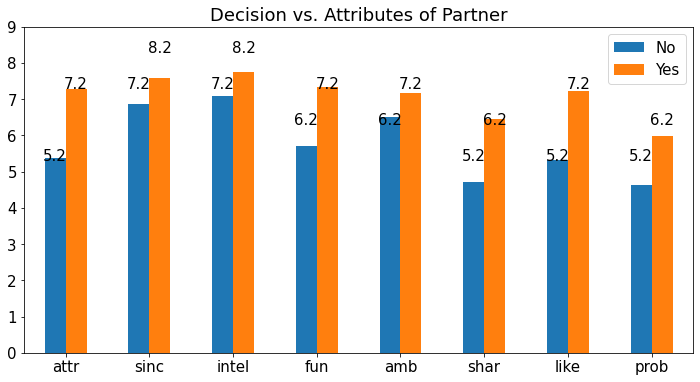

In [ ]:
feats_partner = ['attr', 'sinc', 'intel', 'fun', 'amb', 'shar', 'like', 'prob']

df_decision_partner = df[feats_partner+decision].groupby('dec').mean().stack().unstack(0)

ax = df_decision_partner.plot(kind='bar', figsize=(12,6))
plt.legend(dec)
ax.set_xticklabels(feats_partner, rotation = 'horizontal')
plt.ylim([0, 9])

plt.title('Decision vs. Attributes of Partner', fontsize=18)
plt.rcParams.update({'font.size': 15})
get_annot(ax=ax, decimal=0, distance_to_bar=0.2)

This is evident that we want to date with partners who we evaluate highly. For each criteria, which ones are more important ?

Text(0.5, 0.98, 'Decision vs. Rate for partner')

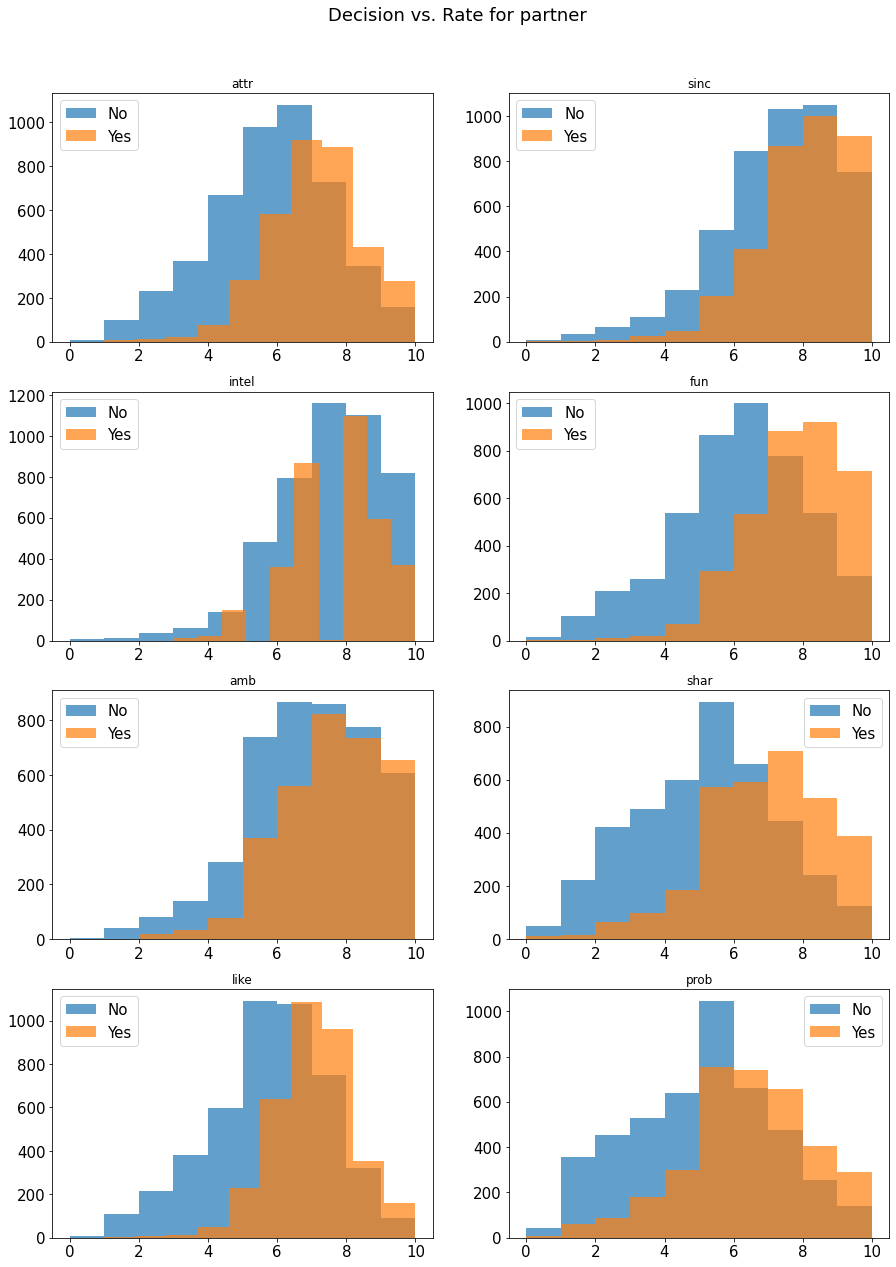

In [ ]:
num = len(feats_partner)
rows = int(num/2) + (num % 2 > 0)
fig, ax = plt.subplots(rows, 2, figsize=(15, 5 * (rows)))
i = 0
j = 0
for feat in feats_partner:
    df[df.dec==0][feat].hist(label='No', ax=ax[i][j], bins=10, alpha=0.7)
    df[df.dec==1][feat].hist(label='Yes', ax=ax[i][j], bins=10, alpha=0.7)
    ax[i][j].set_title(feat, fontsize=12)
    ax[i][j].grid(False)
    ax[i][j].legend()
    j = (j+1)%2
    i = i + 1 - j
    
plt.subplots_adjust(top=0.92)
fig.suptitle('Decision vs. Rate for partner', fontsize=18)

Obviously,more Yes decision for high Attribute, Funny, Shared Interest, Like and only for very high Attractiveness, Ambition

#Summary : 
Until now we have considered groups of criteria : 

1.   Age, Race - SameRace, Importance of Religion, Field

*   Age : more favorite for age between 22-30 years old
*   Race - SameRace : European can have Yes decision quite easilly than other races, but the tendancy is not really clear. While the SameRace doesn't have much influence on decision, but this has real impact on choise of Africain participant. 
*   Importance of Religion : no visual influence 
*   Field : no strong influence

2.   Expectation before Speed Dating
* Goal : less serious expectation, more easily to say Yes
*   Exp. of happiness, date, matches : less expectation, more easily to say Yes
*   Expectation of attribution of opposite sex : Man looks for Attractiveness, while woman looks for Ambition

3.  Habit & Interest : 
* Go-out : the more frequently people goes out, the more easily they say Yes for dating
* Date : the less frequently they have date, the more easily they say Yes. 
* Interest : only high Yes-rate for very high note in interests of  museums, art, clubbing, theater, movies, concerts.


4.   When we meet people at Speed Dating : 
* We want to date with people that we rate highly. 
* More Yes decision for high Attribute, Funny, Shared Interest, Like and only for very high Attractiveness, Ambition



#Correlation between considered features and Decision


# Features of participant
 ['age', 'race', 'imprace','imprelig', 'field_cd']

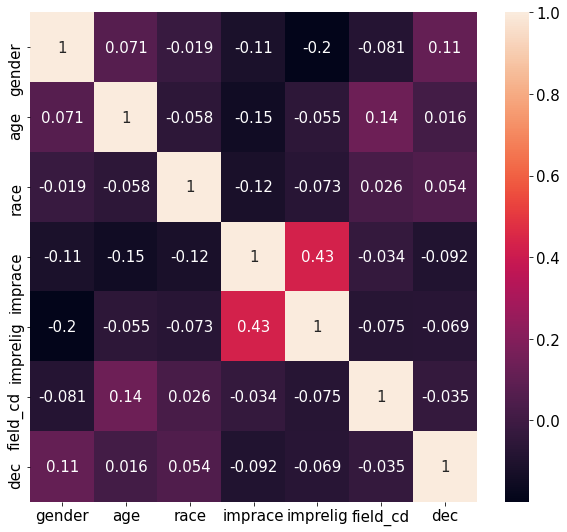

In [ ]:
decision = ['dec']
feats_participant = ['gender', 'age', 'race', 'imprace','imprelig', 'field_cd']
df_participant = df[feats_participant + decision]

fig = plt.subplots(figsize=(10,9))
sns.heatmap(df_participant.corr(), annot=True)

No strong impact observed, except gender (coef. correlation is 0.11)

#Feature : expectation 
['goal', 'exphappy', 'expnum', 'match_es', 'attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']

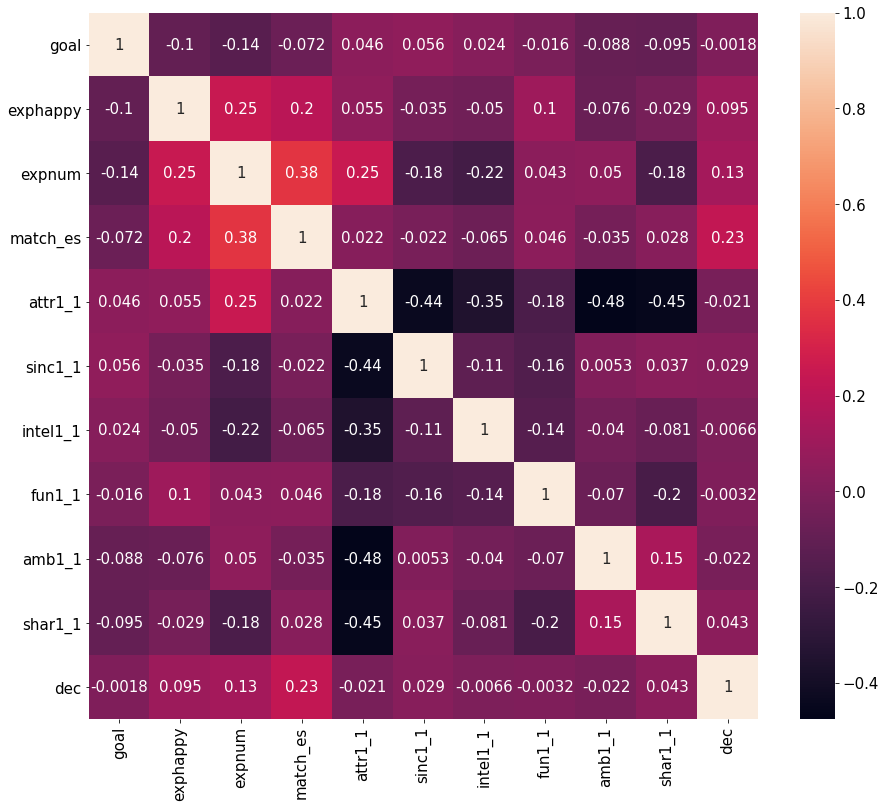

In [ ]:
feats_expect = ['goal', 'exphappy', 'expnum', 'match_es', 'attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']
df_expect = df[feats_expect + decision]

fig = plt.figure(figsize=(15,13))
sns.heatmap(df_expect.corr(), annot=True)

Quite strong correlation between dec and match_es (exp. of match), expnum (exp. of dates, exphappy (exp. of happy)

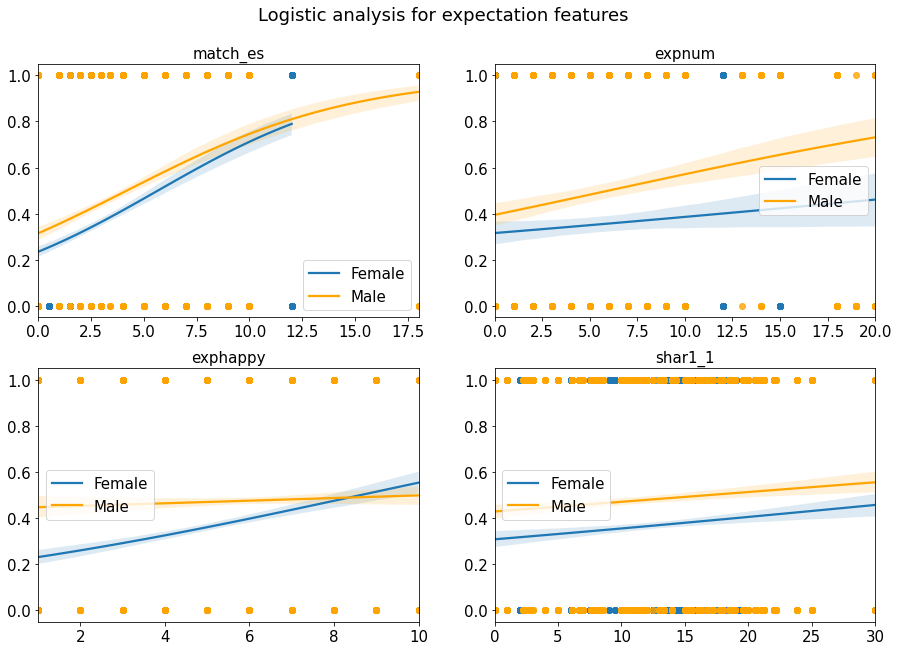

In [ ]:
feats_lookfor = ['match_es', 'expnum', 'exphappy', 'shar1_1']
num = len(feats_lookfor)
rows = int(num/2) + (num % 2 > 0)
fig, ax = plt.subplots(rows, 2, figsize=(15, 5 * (rows)))
i = 0
j = 0
n = 0
for feat in feats_lookfor:
    n = n + 1
    plt.subplot(str(rows)+str(2)+str(n))
    sns.regplot(x=feat, y='dec', data=df[df.gender==0], logistic=True)
    sns.regplot(x=feat, y='dec', data=df[df.gender==1], color='orange', logistic=True)

    plt.legend(labels=['Female','Male'], fontsize=15, prop={'size': 15})
    plt.xlabel('')
    plt.ylabel('')
    plt.title(feat, fontsize=15)

    j = (j+1)%2
    i = i + 1 - j

plt.subplots_adjust(top=0.9)
fig.suptitle('Logistic analysis for expectation features', fontsize=18)
plt.show()

Quite strong logistic tendency of match_es as a function of decision is observed for both genders, espacially for man.

#Habit & Interest
['go_out', 'date', 'sports',	'tvsports',	'exercise',	'dining',	'museums',	'art',	'hiking',	'gaming','clubbing',	'reading',	'tv',	'theater',	'movies',	'concerts',	'music',	'shopping',	'yoga']

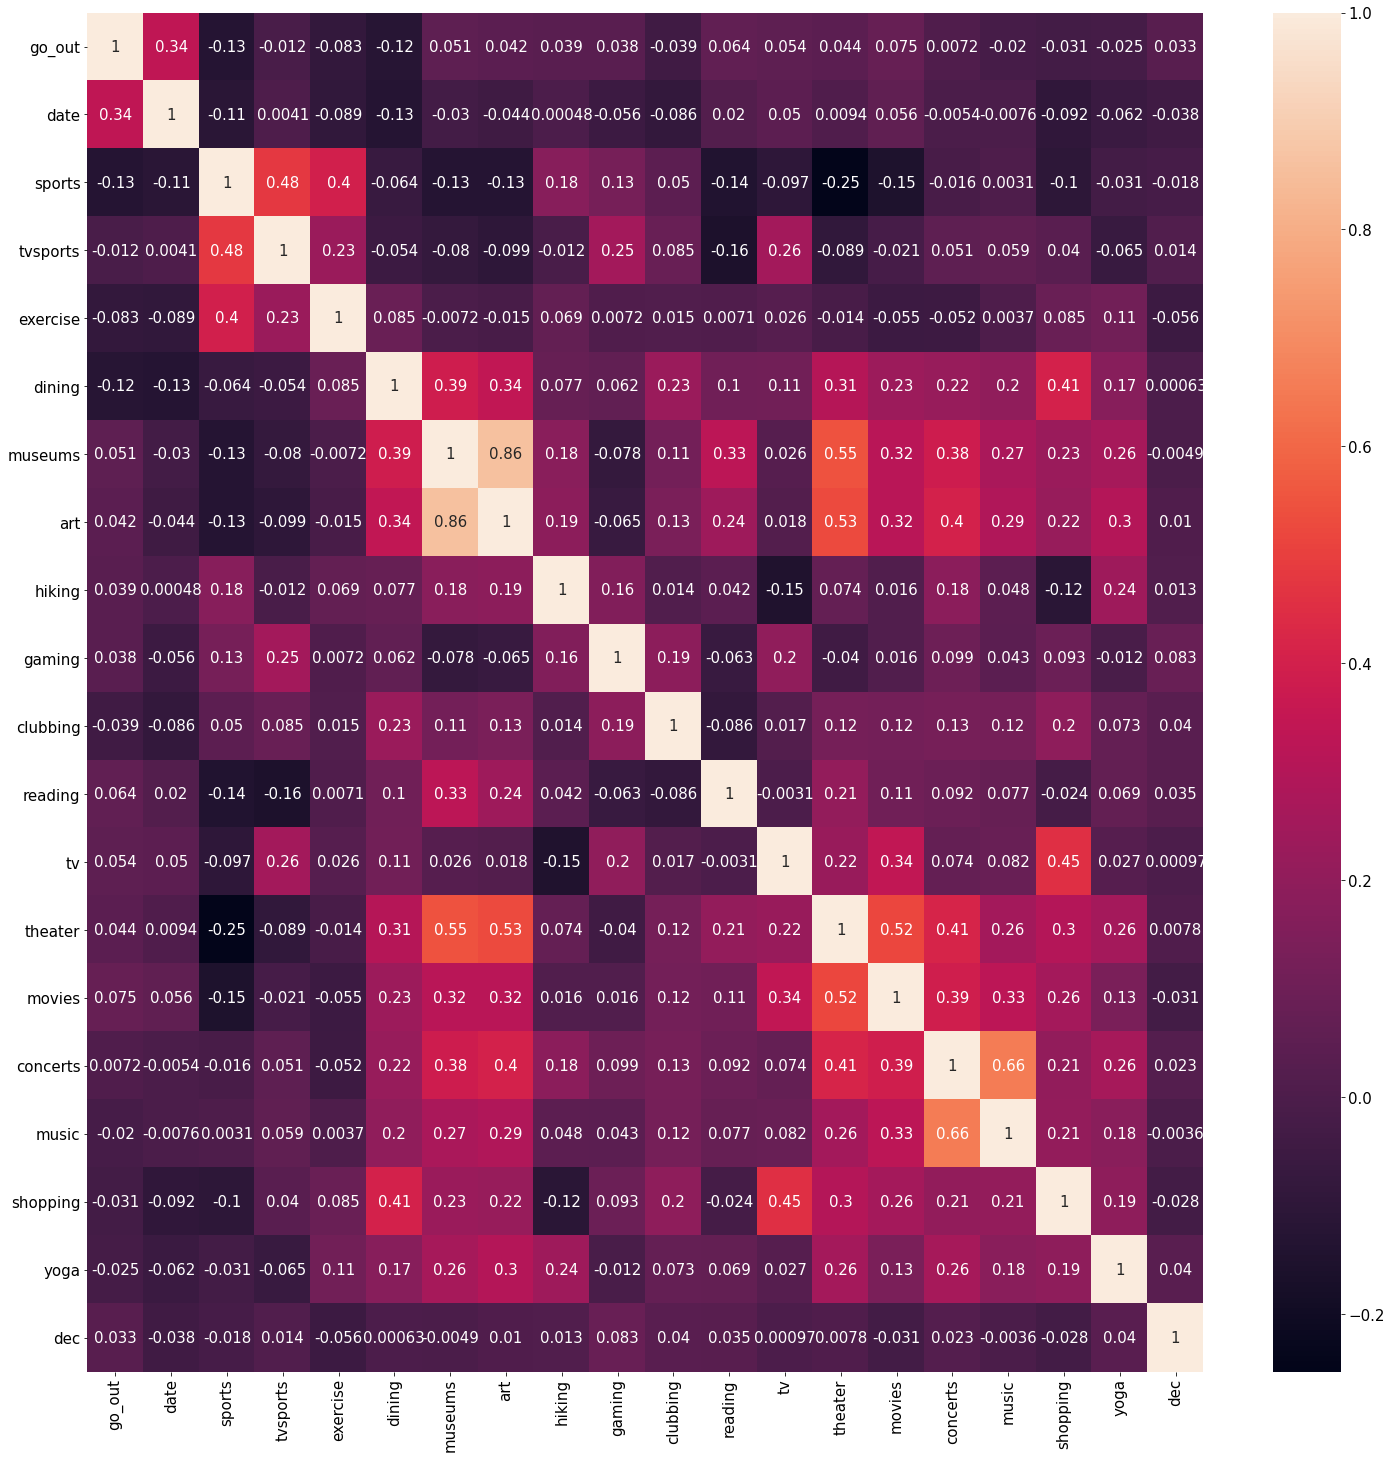

In [ ]:
feats_habit = ['go_out', 'date', 'sports',	'tvsports',	'exercise',	'dining',	'museums',	'art',	'hiking',	'gaming',
                'clubbing',	'reading',	'tv',	'theater',	'movies',	'concerts',	'music',	'shopping',	'yoga']
df_habit = df[feats_habit + decision]

fig = plt.figure(figsize=(25,25))
sns.heatmap(df_habit.corr(), annot=True)

In [ ]:
abs(df_habit.corr()['dec']).sort_values(ascending=False)

dec         1.000000
gaming      0.083472
exercise    0.056415
yoga        0.039920
clubbing    0.039772
date        0.037687
reading     0.035466
go_out      0.032565
movies      0.031152
shopping    0.028189
concerts    0.022550
sports      0.018469
tvsports    0.014082
hiking      0.012811
art         0.010316
theater     0.007804
museums     0.004912
music       0.003606
tv          0.000970
dining      0.000628
Name: dec, dtype: float64

No explicit impact observed on decision

#Partner features & rating
age_o	race_o	pf_o_att	pf_o_sin	pf_o_int	pf_o_fun	pf_o_amb	pf_o_sha	dec_o	attr_o	sinc_o	intel_o	fun_o	amb_o	shar_o	like_o	prob_o	met_o

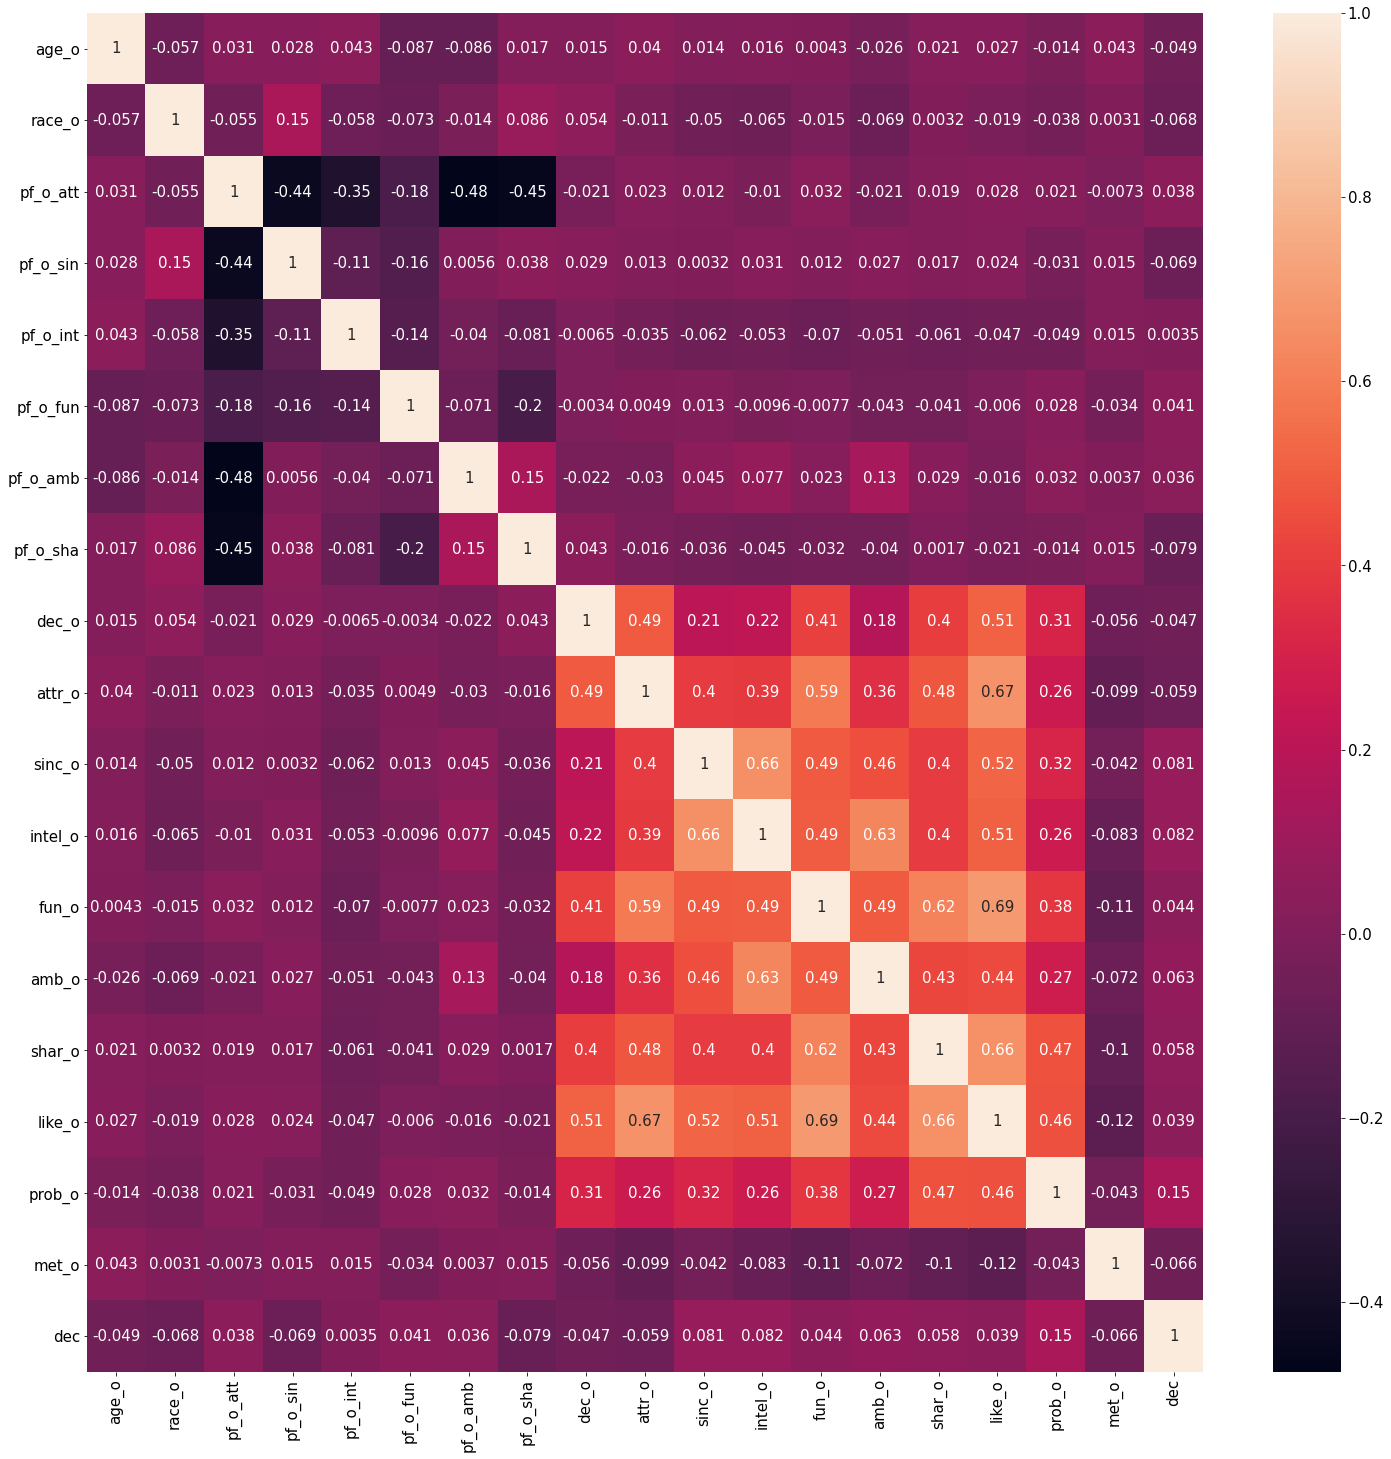

In [ ]:
partner = ['age_o',	'race_o',	'pf_o_att',	'pf_o_sin',	'pf_o_int',	'pf_o_fun',	'pf_o_amb',	'pf_o_sha',	
           'dec_o',	'attr_o',	'sinc_o',	'intel_o',	'fun_o',	'amb_o',	'shar_o',	'like_o',	'prob_o',	'met_o']

df_partner = df[partner + decision]

fig = plt.figure(figsize=(25,25))
sns.heatmap(df_partner.corr(), annot=True)

In [ ]:
abs(df_partner.corr())['dec'].sort_values(ascending=False)

dec         1.000000
prob_o      0.150634
intel_o     0.081869
sinc_o      0.081447
pf_o_sha    0.079243
pf_o_sin    0.069217
race_o      0.068101
met_o       0.065540
amb_o       0.063330
attr_o      0.059360
shar_o      0.057808
age_o       0.049387
dec_o       0.047038
fun_o       0.044162
pf_o_fun    0.041369
like_o      0.038860
pf_o_att    0.037882
pf_o_amb    0.036339
pf_o_int    0.003488
Name: dec, dtype: float64

* Only correlation between prob_o & decision is quite significant, while other features don't show strong impact. 
* High prob_o shows that partners want potentiellaly to date with this participant. 

No handles with labels found to put in legend.


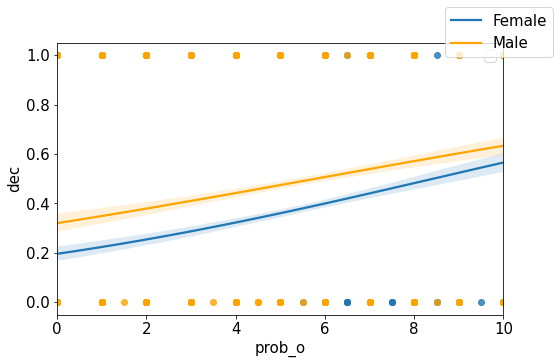

In [ ]:
fig = plt.figure(figsize=(8,5))
sns.regplot(x='prob_o', y='dec', data=df[df.gender==0], logistic=True)
sns.regplot(x='prob_o', y='dec', data=df[df.gender==1], color='orange', logistic=True)
fig.legend(labels=['Female','Male'], fontsize=15)
plt.legend(prop={'size': 15})
plt.show()

#Features : rate
['attr', 'sinc', 'intel', 'fun', 'amb', 'shar', 'like', 'prob', 'met']

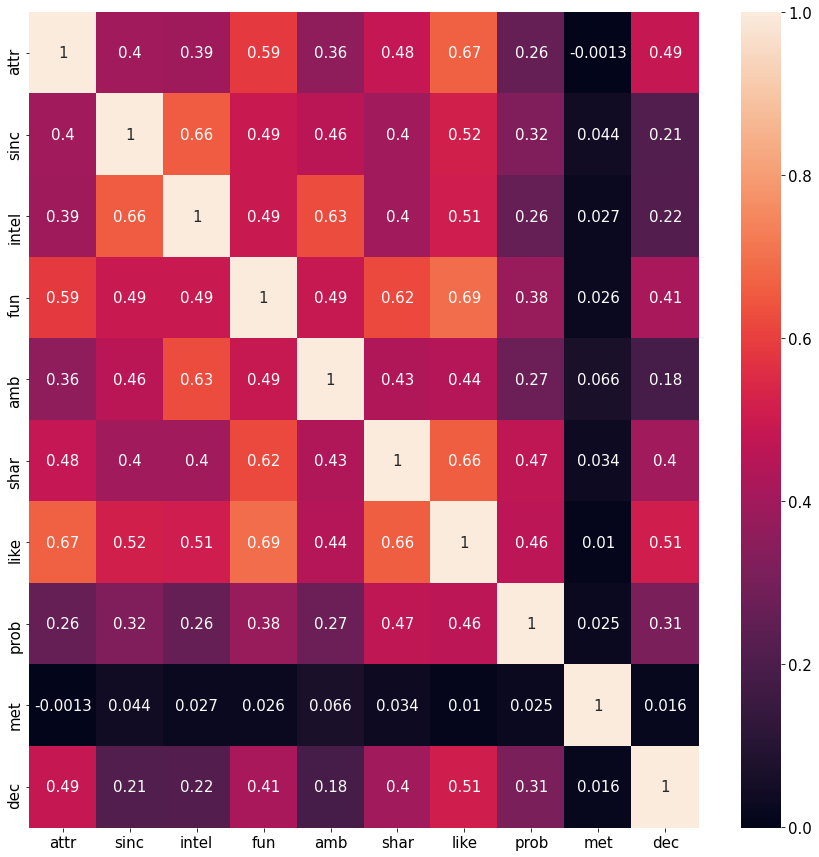

In [ ]:
feats_rate = ['attr', 'sinc', 'intel', 'fun', 'amb', 'shar', 'like', 'prob', 'met']
df_rate = df[feats_rate + decision]

fig = plt.figure(figsize=(15,15))
sns.heatmap(df_rate.corr(), annot=True)

In [ ]:
abs(df_rate.corr())['dec'].sort_values(ascending=False)

dec      1.000000
like     0.513463
attr     0.486775
fun      0.414477
shar     0.400644
prob     0.310861
intel    0.217313
sinc     0.209994
amb      0.183659
met      0.016100
Name: dec, dtype: float64

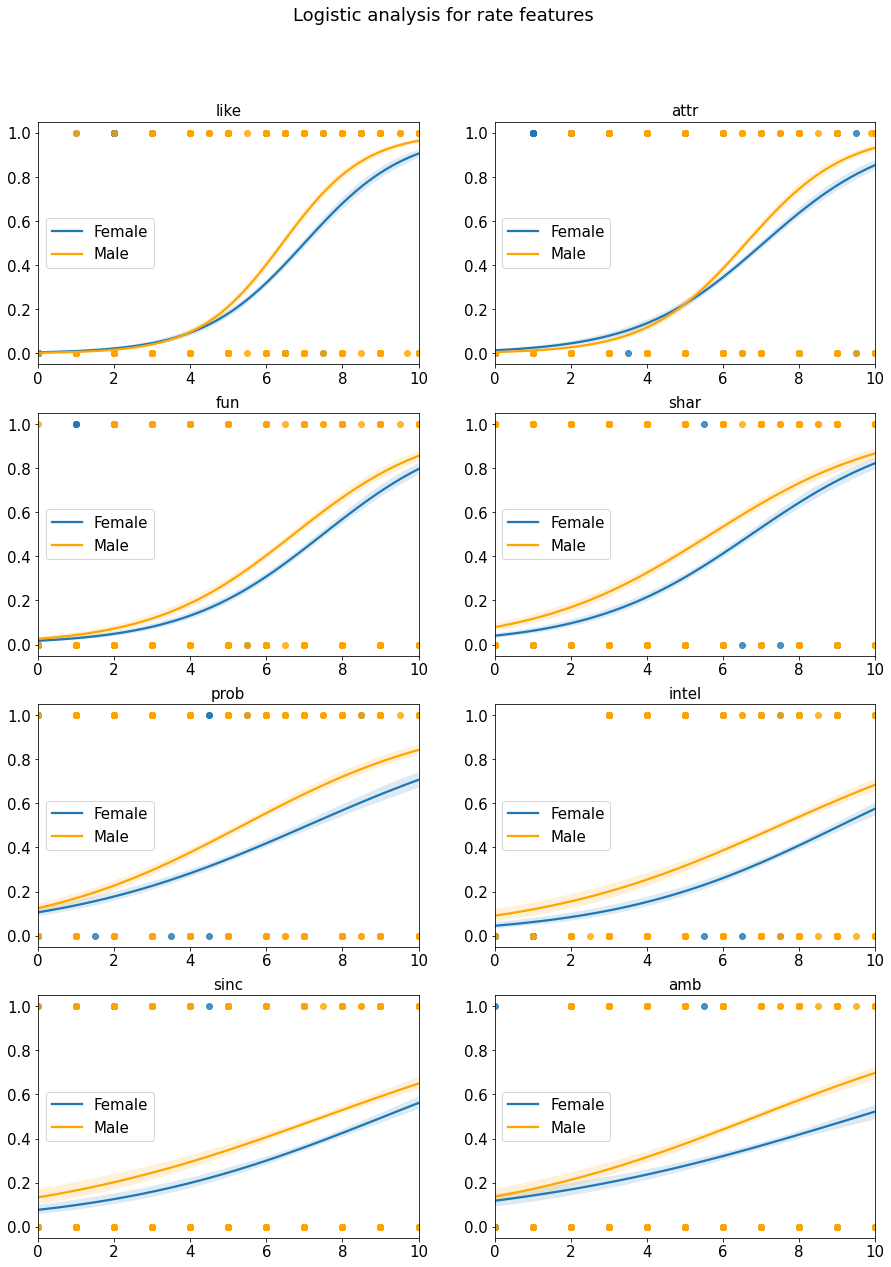

In [ ]:
feats = ['like', 'attr', 'fun', 'shar', 'prob', 'intel', 'sinc', 'amb']

num = len(feats)
rows = int(num/2) + (num % 2 > 0)
fig, ax = plt.subplots(rows, 2, figsize=(15, 5 * (rows)))
i = 0
j = 0
n = 0
for feat in feats:
    n = n + 1
    plt.subplot(str(rows)+str(2)+str(n))
    sns.regplot(x=feat, y='dec', data=df[df.gender==0], logistic=True)
    sns.regplot(x=feat, y='dec', data=df[df.gender==1], color='orange', logistic=True)

    plt.legend(labels=['Female','Male'], fontsize=15, prop={'size': 15})
    plt.xlabel('')
    plt.ylabel('')
    plt.title(feat, fontsize=15)

    j = (j+1)%2
    i = i + 1 - j

plt.subplots_adjust(top=0.9)
fig.suptitle('Logistic analysis for rate features', fontsize=18)
plt.show()

Strong logistic correlation between like, attractiveness, fun and shared interest with Decision, especially for man.

#Matching between participant & partner

#Participant features

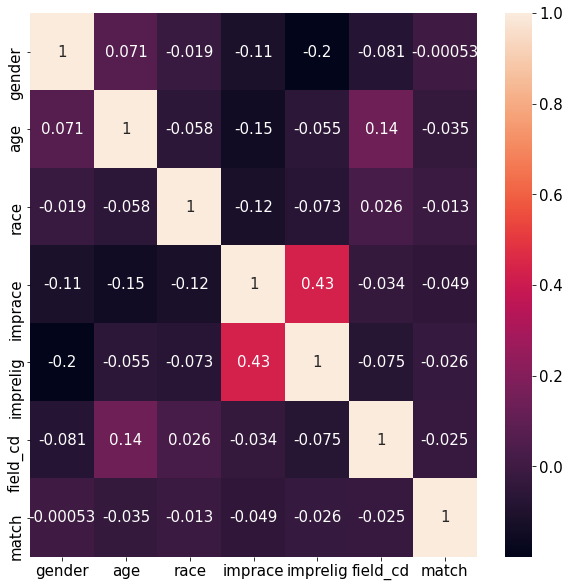

In [ ]:
#feats_participant = ['age', 'race', 'imprace','imprelig', 'field_cd']
match = ['match']

df_participant_match = df[feats_participant  + match]

fig = plt.figure(figsize=(10,10))
sns.heatmap(df_participant_match.corr(), annot=True)

No explicit correlation observed

#Expectation features

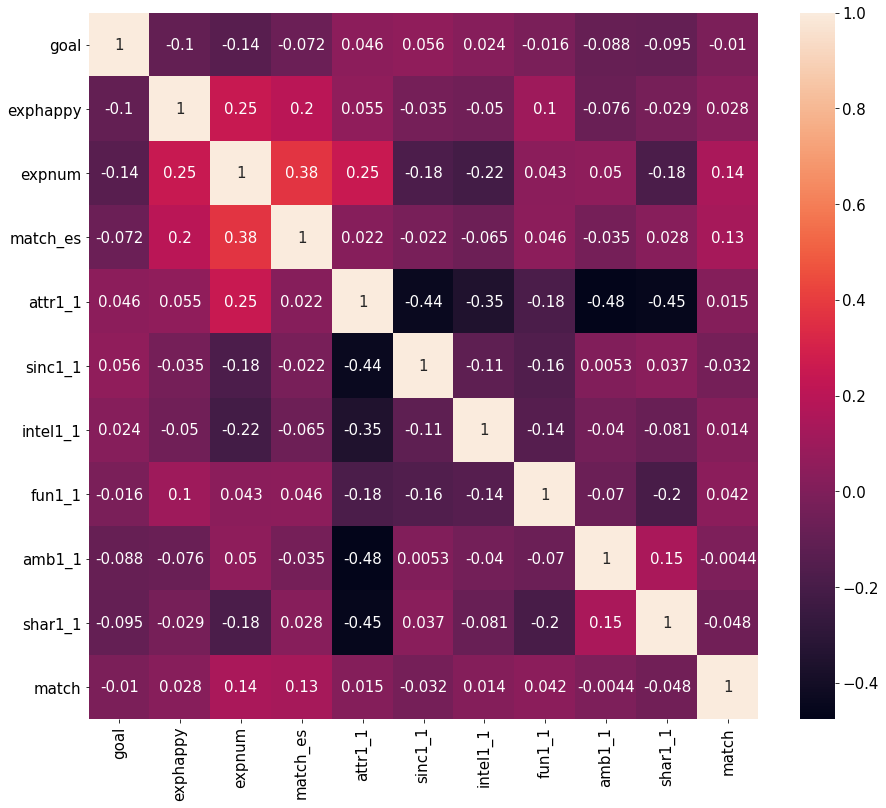

In [ ]:
#feats_expect = ['goal', 'exphappy', 'expnum', 'match_es', 'attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']

df_expect_match = df[feats_expect  + match]

fig = plt.figure(figsize=(15,13))
sns.heatmap(df_expect_match.corr(), annot=True)

In [ ]:
abs(df_expect_match.corr())['match'].sort_values(ascending=False)

match       1.000000
expnum      0.143755
match_es    0.130592
shar1_1     0.048318
fun1_1      0.041652
sinc1_1     0.032325
exphappy    0.027880
attr1_1     0.014950
intel1_1    0.014087
goal        0.010306
amb1_1      0.004444
Name: match, dtype: float64

match_es, expnum have quite strong correlation with match

#Habit vs Match

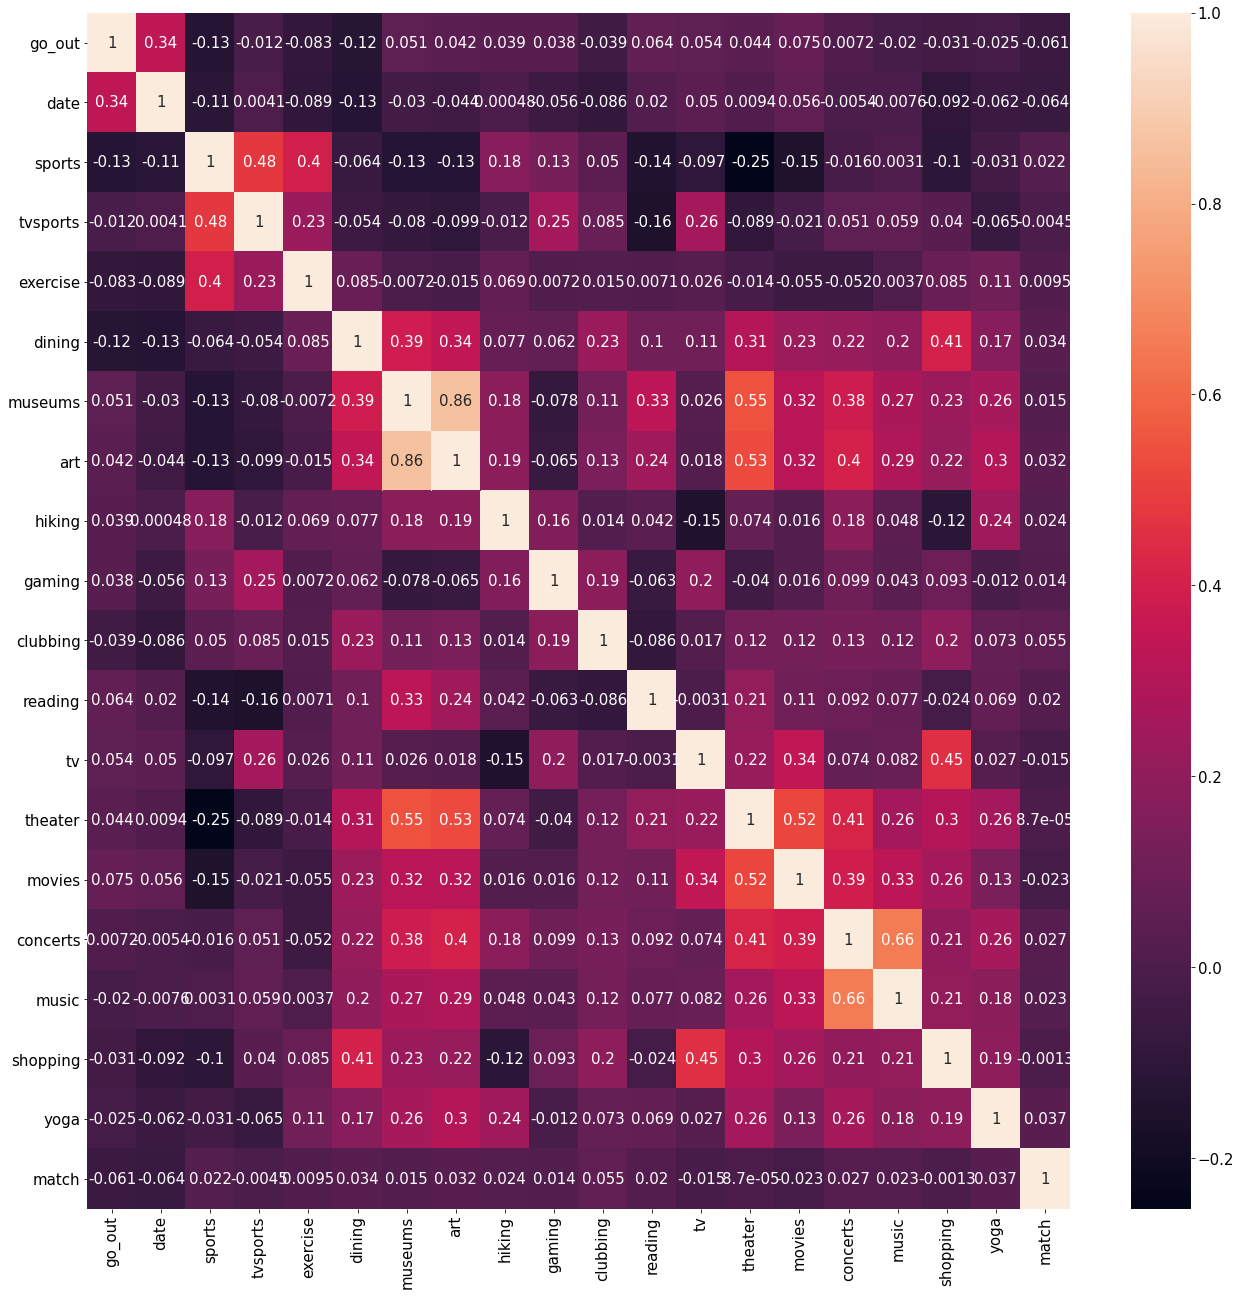

In [ ]:
#feats_habit = ['go_out', 'date', 'sports',	'tvsports',	'exercise',	'dining',	'museums',	'art',	'hiking',	'gaming',
#                'clubbing',	'reading',	'tv',	'theater',	'movies',	'concerts',	'music',	'shopping',	'yoga']
df_habit_match = df[feats_habit  + match]

fig = plt.figure(figsize=(22,22))
sns.heatmap(df_habit_match.corr(), annot=True)

In [ ]:
abs(df_habit_match.corr())['match'].sort_values(ascending=False)

match       1.000000
date        0.063610
go_out      0.060526
clubbing    0.055435
yoga        0.036601
dining      0.033912
art         0.031545
concerts    0.027034
hiking      0.024143
music       0.023093
movies      0.022989
sports      0.021666
reading     0.020222
museums     0.014954
tv          0.014542
gaming      0.013543
exercise    0.009470
tvsports    0.004472
shopping    0.001333
theater     0.000087
Name: match, dtype: float64

No explicit correlation observed

#Rating of participant vs Match

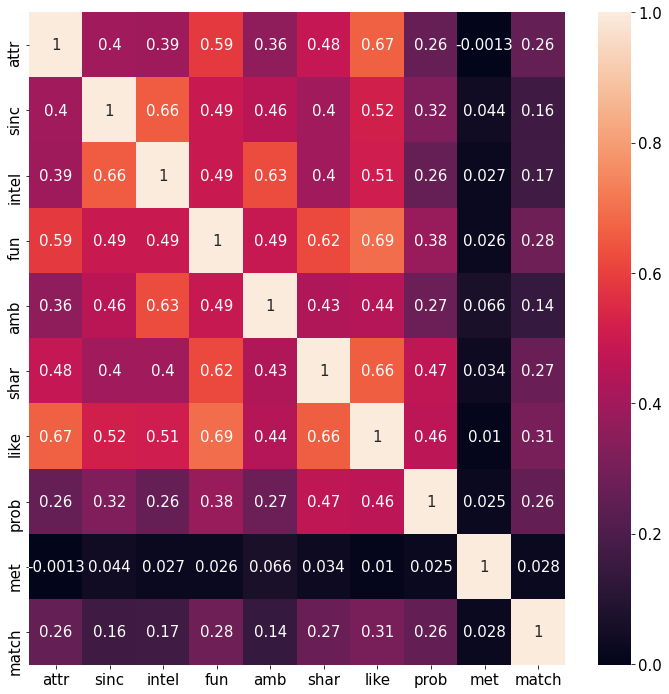

In [ ]:
#feats_rate = ['attr', 'sinc', 'intel', 'fun', 'amb', 'shar', 'like', 'prob', 'met']
df_rate_match = df[feats_rate  + match]

fig = plt.figure(figsize=(12,12))
sns.heatmap(df_rate_match.corr(), annot=True)

In [ ]:
abs(df_rate_match.corr())['match'].sort_values(ascending=False)

match    1.000000
like     0.305723
fun      0.277545
shar     0.270679
attr     0.260676
prob     0.255531
intel    0.169532
sinc     0.164449
amb      0.140042
met      0.027670
Name: match, dtype: float64

Like, fun, share, attr, prob, intel, sinc, amb have quite strong impact on the match

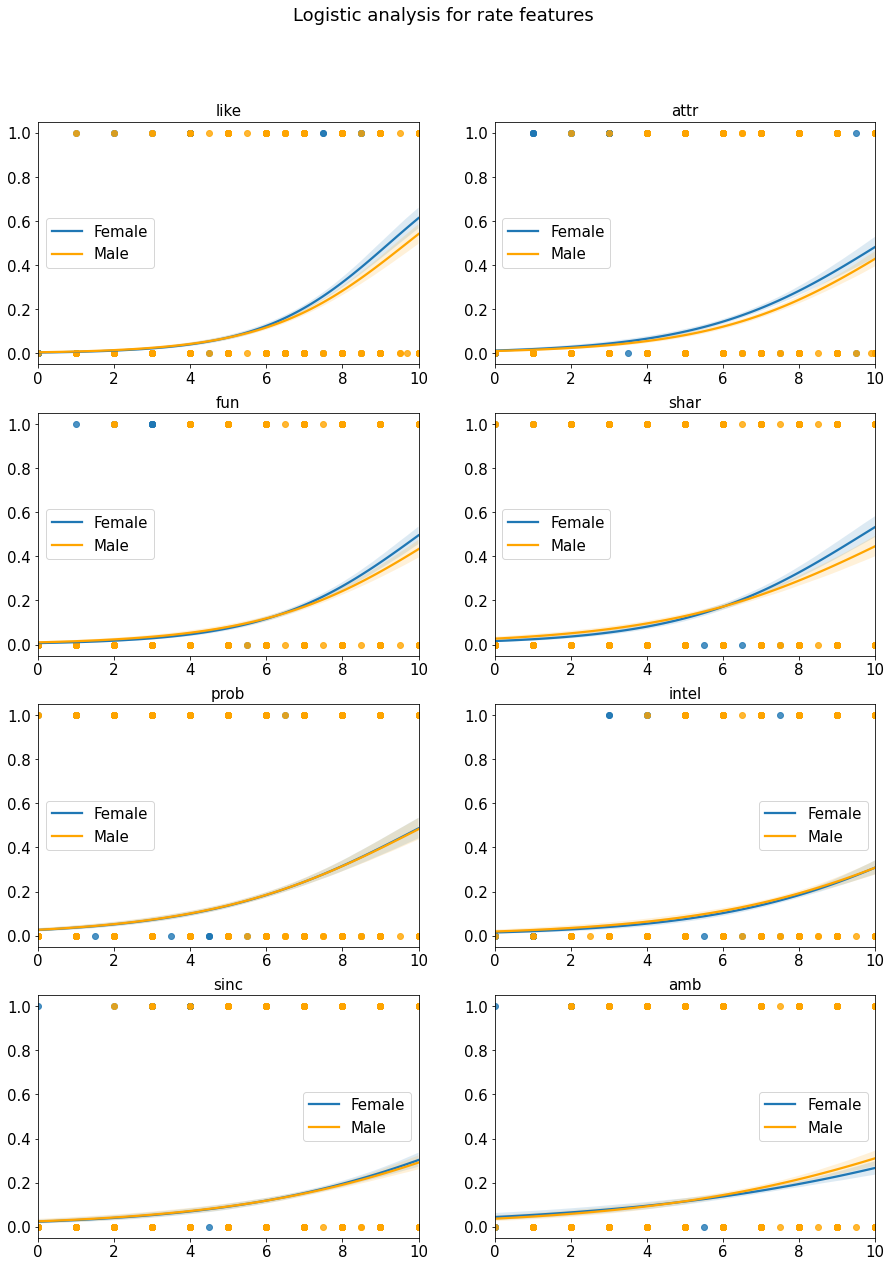

In [ ]:
feats = ['like', 'attr', 'fun', 'shar', 'prob', 'intel', 'sinc', 'amb']

num = len(feats)
rows = int(num/2) + (num % 2 > 0)
fig, ax = plt.subplots(rows, 2, figsize=(15, 5 * (rows)))
i = 0
j = 0
n = 0
for feat in feats:
    n = n + 1
    plt.subplot(str(rows)+str(2)+str(n))
    sns.regplot(x=feat, y='match', data=df[df.gender==0], logistic=True)
    sns.regplot(x=feat, y='match', data=df[df.gender==1], color='orange', logistic=True)

    plt.legend(labels=['Female','Male'], fontsize=15, prop={'size': 15})
    plt.xlabel('')
    plt.ylabel('')
    plt.title(feat, fontsize=15)

    j = (j+1)%2
    i = i + 1 - j

plt.subplots_adjust(top=0.9)
fig.suptitle('Logistic analysis for rate features', fontsize=18)
plt.show()

#Rating of partner vs Match

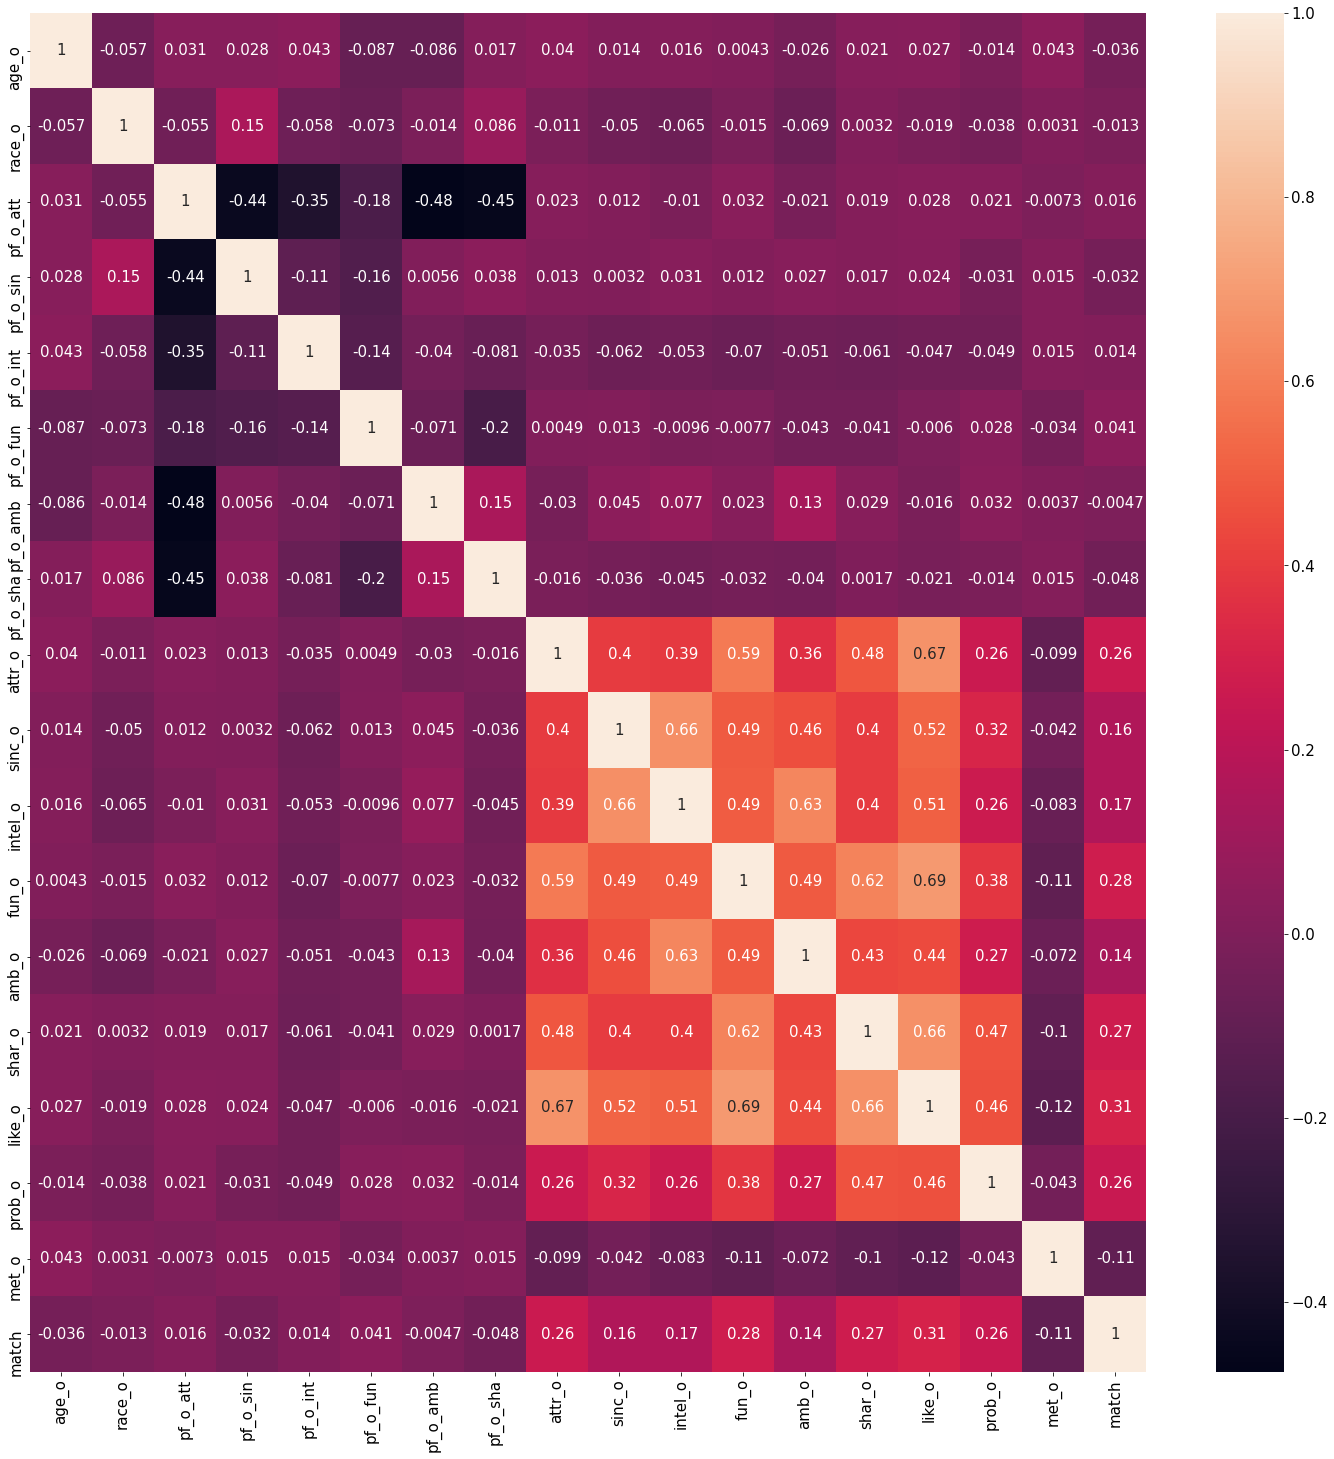

In [ ]:
partner = ['age_o',	'race_o',	'pf_o_att',	'pf_o_sin',	'pf_o_int',	'pf_o_fun',	'pf_o_amb',	'pf_o_sha',	
           'attr_o',	'sinc_o',	'intel_o',	'fun_o',	'amb_o',	'shar_o',	'like_o',	'prob_o',	'met_o']

df_partner_match = df[partner + match]

fig = plt.figure(figsize=(25,25))
sns.heatmap(df_partner_match.corr(), annot=True)

In [ ]:
abs(df_partner_match.corr())['match'].sort_values(ascending=False)

match       1.000000
like_o      0.305853
fun_o       0.277700
shar_o      0.270840
attr_o      0.260837
prob_o      0.255574
intel_o     0.169448
sinc_o      0.164523
amb_o       0.139927
met_o       0.106569
pf_o_sha    0.048399
pf_o_fun    0.041483
age_o       0.035865
pf_o_sin    0.032391
pf_o_att    0.015663
pf_o_int    0.013761
race_o      0.013088
pf_o_amb    0.004650
Name: match, dtype: float64

As for participant, their partners will decide going to the next date base on : like_o, fun_o, shar_o, attr_o, prob_o, intel_o, sinc_o, amb_o, met_o

Until now, we have seen a lot of features that influence on the decision of people during the Speed Dating. 
To reminder : 
* Participant features : only gender type show an explicit impact on decision & match
* Quite strong correlation between dec, match and expnum (exp. of dates),  match_es (exp. of match)
* Habit & Interests : No explicit impact observed on decision
* Rating of participant and partner : Strong correlation between 6 important attributions and shared interest with Decision, Match.

# Classification models : DecisionTreeClassifier, RandomForestClassifier, GradientBoostingClassifier

In [ ]:
decision = ['dec']
match = ['match']

#Features of participant
feats_participant = ['gender','age', 'race', 'imprace','imprelig', 'field_cd']
feats_expect = ['goal', 'exphappy', 'expnum', 'match_es', 'attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']
feats_habit = ['go_out', 'date', 'sports',	'tvsports',	'exercise',	'dining',	'museums',	'art',	'hiking',	'gaming',
                'clubbing',	'reading',	'tv',	'theater',	'movies',	'concerts',	'music',	'shopping',	'yoga']
#Features of rate for partner
feats_participant_rate = ['attr', 'sinc', 'intel', 'fun', 'amb', 'shar', 'like', 'prob', 'met']

#Features of partner
feats_partner = ['age_o',	'race_o',	'pf_o_att',	'pf_o_sin',	'pf_o_int',	'pf_o_fun',	'pf_o_amb',	'pf_o_sha']	
feats_partner_rate = ['attr_o',	'sinc_o',	'intel_o',	'fun_o',	'amb_o',	'shar_o',	'like_o',	'prob_o',	'met_o']


#all features
feats_all = feats_participant + feats_expect + feats_habit + feats_participant_rate + feats_partner + feats_partner_rate + match

df_all_feats = df[feats_all]

#only features with strong correlation with decision 
#feats_strongCorrelation = ['gender',
#                           'match_es', 'exphappy',
#                           'like_o', 'fun_o', 'shar_o', 'attr_o', 'prob_o', 'intel_o', 'sinc_o', 'amb_o', 'met_o',
#                           'like', 'fun', 'shar', 'attr', 'prob', 'intel', 'sinc', 'amb', 'match']


#Find null value

In [ ]:
for feat in df_all_feats.columns:
    empty_vals = df_all_feats[feat].isnull().sum()
    if empty_vals > 0:
        print("{}: {} missing, {}%".format(feat, empty_vals, (round(empty_vals/df_all_feats.shape[0] * 100, 4))))
        if empty_vals/df_all_feats.shape[0] * 100 > 50:
            print('REMOUVE features: ', feat)
            feats_all.remove(feat)
            del df_all_feats[feat]
            print()


age: 95 missing, 1.1339%
race: 63 missing, 0.752%
imprace: 79 missing, 0.9429%
imprelig: 79 missing, 0.9429%
field_cd: 82 missing, 0.9788%
goal: 79 missing, 0.9429%
exphappy: 101 missing, 1.2055%
expnum: 6578 missing, 78.5152%
REMOUVE features:  expnum

match_es: 1173 missing, 14.001%
attr1_1: 79 missing, 0.9429%
sinc1_1: 79 missing, 0.9429%
intel1_1: 79 missing, 0.9429%
fun1_1: 89 missing, 1.0623%
amb1_1: 99 missing, 1.1817%
shar1_1: 121 missing, 1.4443%
go_out: 79 missing, 0.9429%
date: 97 missing, 1.1578%
sports: 79 missing, 0.9429%
tvsports: 79 missing, 0.9429%
exercise: 79 missing, 0.9429%
dining: 79 missing, 0.9429%
museums: 79 missing, 0.9429%
art: 79 missing, 0.9429%
hiking: 79 missing, 0.9429%
gaming: 79 missing, 0.9429%
clubbing: 79 missing, 0.9429%
reading: 79 missing, 0.9429%
tv: 79 missing, 0.9429%
theater: 79 missing, 0.9429%
movies: 79 missing, 0.9429%
concerts: 79 missing, 0.9429%
music: 79 missing, 0.9429%
shopping: 79 missing, 0.9429%
yoga: 79 missing, 0.9429%
attr: 2

expnum : has a slight impact on decision, but this features has lots of empty values (78.5%). I will not consider this feature in model.

In [ ]:
#REPLACE NULL BY "Mode"
for col in df_all_feats.columns:
    df_all_feats[col].fillna(df_all_feats[col].mode()[0], inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [ ]:
df_all_feats.describe(include='all')

gender          age  ...        met_o        match
count  8378.000000  8378.000000  ...  8378.000000  8378.000000
mean      0.500597    26.366197  ...     1.962043     0.164717
std       0.500029     3.547130  ...     0.240352     0.370947
min       0.000000    18.000000  ...     1.000000     0.000000
25%       0.000000    24.000000  ...     2.000000     0.000000
50%       1.000000    26.000000  ...     2.000000     0.000000
75%       1.000000    28.000000  ...     2.000000     0.000000
max       1.000000    55.000000  ...     8.000000     1.000000

[8 rows x 61 columns]

In [ ]:
X = df_all_feats.drop('match', axis=1)
y = df_all_feats['match']

#Train test split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
#With Statify 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
print('Class - total elements in TRAIN set :', Counter(y_train))
print('Class - total elements in TEST set :', Counter(y_test))

#Scaler
#col_scaler = [col for col in X.columns if col not in col_dummies]
#scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test)

Class - total elements in TRAIN set : Counter({0: 5598, 1: 1104})
Class - total elements in TEST set : Counter({0: 1400, 1: 276})


In [ ]:
classifiers = [DecisionTreeClassifier(), RandomForestClassifier(), GradientBoostingClassifier() ]
clf_names = ["decision_tree",  "random_forest", "gradient_boosting"]

train_score = []
test_score = []
for index, classifier in enumerate(classifiers):
    print(index)
    #print(classifier)
    classifier.fit(X_train, y_train)
    train_score.append(round(classifier.score(X_train, y_train),4))
    test_score.append(round(classifier.score(X_test, y_test),4))

print("Train score : ", train_score)
print("Test score: ", test_score)

0
1
2
Train score :  [1.0, 1.0, 0.8938]
Test score:  [0.8019, 0.8568, 0.8693]


* Tree, RandomForest : Overfitting
* GradientBoosting give good prediction with train score of 89% & test score of 87%

In [ ]:
Gboost = GradientBoostingClassifier()

params_grid = [{'learning_rate': [0.05, 0.1, 0.5],
                'n_estimators': [50, 100, 200, 300]}]
kfold = 5
k = StratifiedKFold(n_splits=kfold)

gb_clf = GridSearchCV(Gboost, param_grid=params_grid, cv = k)
gb_clf.fit(X_train, y_train)

#Best estimator
best_gb = gb_clf.best_estimator_
print(best_gb)

#Mean score on train set 
train_score_gb = np.mean(cross_val_score(gb_clf, X_train, y_train, cv=kfold))
print(train_score_gb)

#Test score 
test_score_xgb = best_gb.score(X_test, y_test)
print(test_score_xgb)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.05, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=300,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
0.8721280621500996
0.8711217183770883


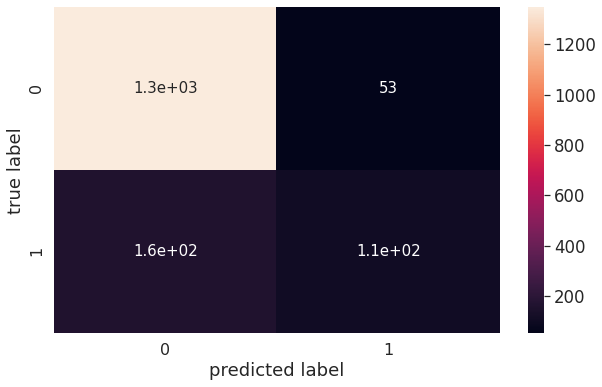

In [ ]:
best_gb.fit(X_train, y_train)
y_pred = best_gb.predict(X_test)

#Heatmap of confusion matrix
plt.figure(figsize=(10,6))
ax = sns.heatmap(confusion_matrix(y_test,y_pred), annot=True)
sns.set(font_scale=1.5)
cbar.ax.tick_params(labelsize=20)
ax.set_xlabel('predicted label')
ax.set_ylabel('true label')
plt.tick_params(labelsize=16)
plt.show()


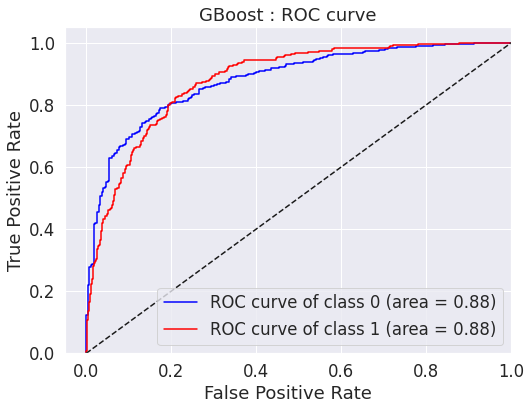

In [ ]:
n_classes = y.value_counts().shape[0] #Number of classes
y_score = best_gb.fit(X_train, y_train).predict_proba(X_test)
# Compute ROC curve and ROC area for each class
get_ROC(n_classes=n_classes, y_target=y_test, y_score_probas = y_score)

AUC of ROC for two classes are 0.88

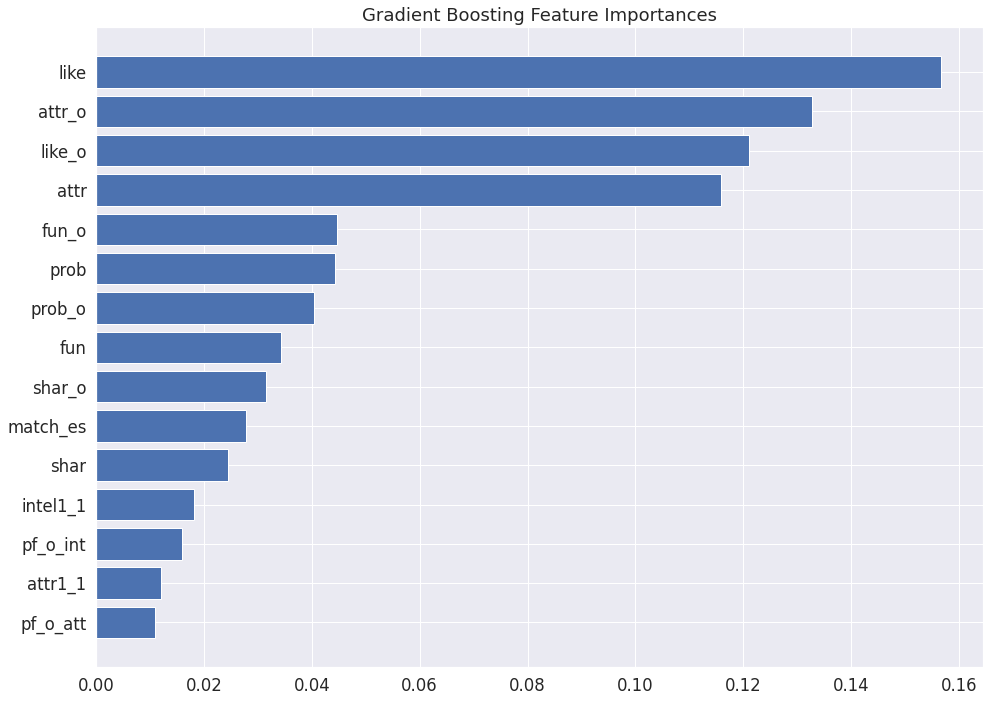

In [ ]:
GB_feature_importances = best_gb.feature_importances_
feature_names = X.columns
#print(tree_feature_importances.shape)

n=15
sorted_idx = GB_feature_importances.argsort()[::-1][:n]

y_ticks = np.arange(0, len(feature_names[sorted_idx]))
fig, ax = plt.subplots(1, 1, figsize=(14,10))
ax.barh(y_ticks, GB_feature_importances[sorted_idx])
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_yticks(y_ticks)
ax.invert_yaxis()

ax.set_title("Gradient Boosting Feature Importances")
fig.tight_layout()
plt.show()

Like and attractiveness show their impact on model, as seen before in Visualization section. 

#RandomOverSampling 
Generate more data for the class 1 of "match" (target)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Berfore RandomOverSampler : Classe - Count: 
 0    5598
1    1104
Name: match, dtype: int64
After RandomeSampler : Classe - Count 
 Counter({0: 5598, 1: 2799})
Accuracy score after Over Sampling:  0.8562581874478981



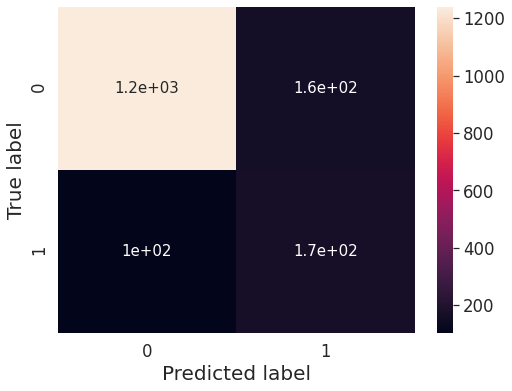

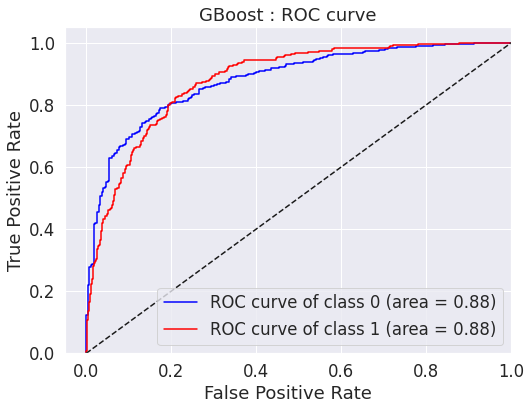

In [ ]:
ros = RandomOverSampler(sampling_strategy=0.5)
X_ros, y_ros = ros.fit_sample(X_train, y_train)
print('Berfore RandomOverSampler : Classe - Count: \n', y_train.value_counts())
print('After RandomeSampler : Classe - Count \n', Counter(y_ros))

GB_OverSampling = GradientBoostingClassifier()
GB_OverSampling.fit(X_ros, y_ros)
print('Accuracy score after Over Sampling: ', accuracy_score(y_ros, GB_OverSampling.predict(X_ros)))
print()

#Heatmap of confusion matrix
plt.figure(figsize=(8,6))
ax = sns.heatmap(confusion_matrix(y_test,GB_OverSampling.predict(X_test)), annot=True)
ax.set_xlabel('Predicted label', fontsize=20)
ax.set_ylabel('True label', fontsize=20)
plt.show
print()
#plot ROC
y_score_ros = GB_OverSampling.predict_proba(X_test)
get_ROC(n_classes=n_classes, y_target=y_test, y_score_probas = y_score_ros)

#Under-sampling: Tomek links
Downsample class 0 (account for 84%) of target "match"

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Berfore Under-sampling : Classe - Count: 
 0    5598
1    1104
Name: match, dtype: int64
After Under-sampling : Classe - Count 
 Counter({0: 5249, 1: 1104})
Accuracy score after Under Sampling:  0.8562581874478981



<function matplotlib.pyplot.show>

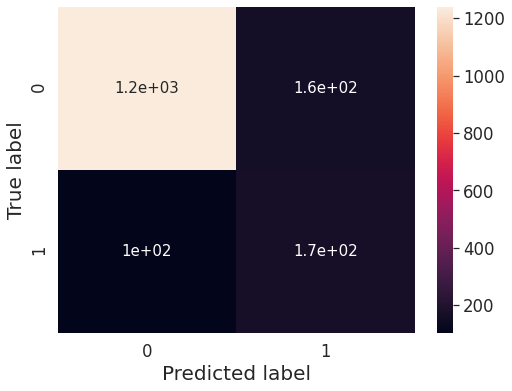

In [ ]:
tl = TomekLinks(return_indices=True, ratio='majority')
X_tl, y_tl, id_tl = tl.fit_sample(X_train, y_train)

print('Berfore Under-sampling : Classe - Count: \n', y_train.value_counts())
print('After Under-sampling : Classe - Count \n', Counter(y_tl))

GB_underSampling = GradientBoostingClassifier()
GB_underSampling.fit(X_ros, y_ros)
print('Accuracy score after Under Sampling: ', accuracy_score(y_ros, GB_underSampling.predict(X_ros)))
print()

#Heatmap of confusion matrix
plt.figure(figsize=(8,6))
ax = sns.heatmap(confusion_matrix(y_test,GB_underSampling.predict(X_test)), annot=True)
ax.set_xlabel('Predicted label', fontsize=20)
ax.set_ylabel('True label', fontsize=20)
plt.show


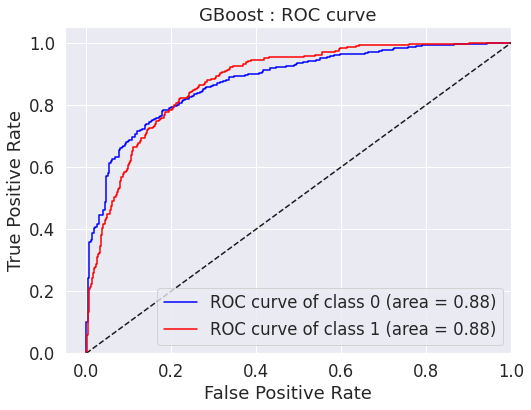

In [ ]:
y_score_tl = GB_underSampling.predict_proba(X_test)
get_ROC(n_classes=n_classes, y_target=y_test, y_score_probas = y_score_tl)

#Over-sampling followed by under-sampling

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Berfore Over-sampling followed by under-sampling : Classe - Count: 
 0    5598
1    1104
Name: match, dtype: int64
After Over-sampling followed by under-sampling  : Classe - Count 
 Counter({0: 5590, 1: 5590})
Accuracy score after Under Sampling:  0.8581089702692357



<function matplotlib.pyplot.show>

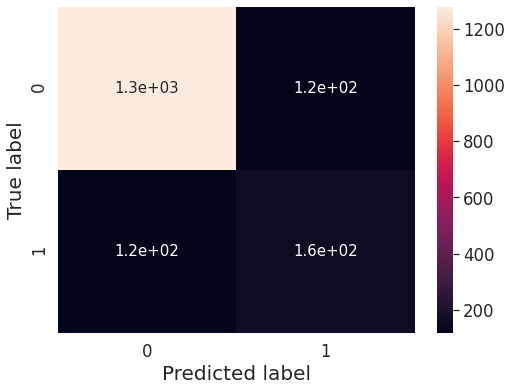

In [ ]:
smt = SMOTETomek(ratio='auto')
X_smt, y_smt = smt.fit_sample(X_train, y_train)

print('Berfore Over-sampling followed by under-sampling : Classe - Count: \n', y_train.value_counts())
print('After Over-sampling followed by under-sampling  : Classe - Count \n', Counter(y_smt))

GB_smt = GradientBoostingClassifier()
GB_smt.fit(X_ros, y_ros)
print('Accuracy score after Under Sampling: ', accuracy_score(y_ros, GB_smt.predict(X_ros)))
print()

#Heatmap of confusion matrix
plt.figure(figsize=(8,6))
ax = sns.heatmap(confusion_matrix(y_test,GB_smt.predict(X_test)), annot=True)
ax.set_xlabel('Predicted label', fontsize=20)
ax.set_ylabel('True label', fontsize=20)
plt.show

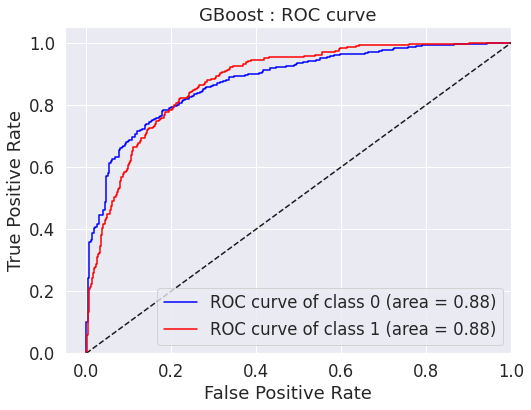

In [ ]:
y_score_smt = GB_smt.predict_proba(X_test)
get_ROC(n_classes=n_classes, y_target=y_test, y_score_probas = y_score_smt)

#CONCLUSION : 
* We have seen various analysis in Visualization section to find principal factors to have Yes decision and a Match between participants. 
* In classification section, GradientBoostingClassifier is quite good on prediction with train - test scores are 90% and 86% respectively. But, the dataset is unbalanced : ratio between match:no-match = 16.5:83.5 = 1:5. So that, even the AUC of ROC for both classes are 0.88, we have a low precision on classe "match" (1). 
I have tried to solve this unbalance probleme with RandomOverSampling, UnderSampling with TomekLinks and Over-sampling followed by under-sampling, the precisions stay at 86%, and AUCs are 0.88 for all cases. 
* In my opnion, some features is lacked, like : city, income, habit, even the size of parner (& participant) that can permit classification models work better. 